In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import Section

In [ ]:
!pip install pythainlp

     |████████████████████████████████| 10.6MB 6.5MB/s 
     |████████████████████████████████| 747kB 35.2MB/s 


In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 7.5MB/s 
     |████████████████████████████████| 14.8MB 334kB/s 
     |████████████████████████████████| 6.5MB 50.9MB/s 


In [ ]:
pip install light-famd

In [ ]:
import re
import sys
import nltk
import pythainlp
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
#from light_famd import FAMD
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import CoherenceModel
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from pythainlp.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df_thaime = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IS/insight/df_thaime.csv")
#df_thaime['project_name_clean'] = df_thaime['project_name']
df_thaime.head()

,project_name,budget,unit,ministry,province,details_url,proj_location,proj_loc,loc_info,address,lat,lng,budget(M),TOKEN,ENG_province,Project_num,project_n,project_name_clean
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,866000.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,https://drive.google.com/file/d/1310udhmdfXYpw...,จ.กระบี่,จ.กระบี่,"Krabi, Thailand | 8.0862997 | 98.9062835 | TH","Krabi, Thailand",8.08630,98.906284,0.8660,"['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน...",Krabi,0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า...,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,448500.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,https://drive.google.com/file/d/1qschiwWNOLsTI...,จ.กระบี่ หมู่ 1 หมู่ 2 หมู่ 3 และ หมู่ 4,จ.กระบี่ หมู่ 1 หมู่ 2 หมู่ 3 และ หมู่ 4,"Moo 4, Tambon Ao Nang, Amphoe Mueang Krabi, Ch...","Moo 4, Tambon Ao Nang, Amphoe Mueang Krabi, Ch...",8.06172,98.859268,0.4485,"['พัฒนา', 'ศักยภาพ', 'เสริมสร้าง', 'ความเข้มแข...",Krabi,1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,200000000.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,https://drive.google.com/file/d/1waJkTk6aEETHZ...,ม.7 ต.ไสไทย อ.เมือง จ.กระบี่,ม.7 ต.ไสไทย อ.เมือง จ.กระบี่,339 หมู่7 ตำบลไสไทย อำเภอเมือง อำเภอเมือง Amph...,339 หมู่7 ตำบลไสไทย อำเภอเมือง อำเภอเมือง Amph...,8.05123,98.907375,200.0000,"['ศูนย์', 'สั่งการ', 'ความปลอดภัย', 'เชิง', 'บ...",Krabi,2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,15000000.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,https://drive.google.com/file/d/1bEsPvcIRY3ghL...,จังหวัดกระบี่,จังหวัดกระบี่,"Krabi, Thailand | 8.0862997 | 98.9062835 | TH","Krabi, Thailand",8.08630,98.906284,15.0000,"['เพิ่มประสิทธิภาพ', 'ดูแลรักษา', 'ความสะอาด',...",Krabi,3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,9750000.0,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,กระบี่,https://drive.google.com/file/d/1A1d5WBukfOFJ0...,จ.กระบี่,จ.กระบี่,"Krabi, Thailand | 8.0862997 | 98.9062835 | TH","Krabi, Thailand",8.08630,98.906284,9.7500,"['ก่อสร้าง', 'ถนน', 'แอ', 'ติก', 'คอนกรีต', 'ช...",Krabi,4,ก่อสร้างถนนแอสฟัลท์ติกคอนกรีต ชั้นพื้นทางดินซี...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...


In [ ]:
df_for_cluster = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IS/insight/df_for_cluster.csv")
df_for_cluster.head(2)

,Project_name,unit,ministry,budget,province,TOKEN,project_name_remove_stopword,cluster,project_name_ori,eng_province
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,"['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",1,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,Krabi
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,"['พัฒนา', 'ศักยภาพ', 'เสริมสร้าง', 'ความเข้มแข...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,Krabi


In [ ]:
df_for_cluster['project_name_ori'] = df_thaime['project_name']
df_for_cluster.head(2)

,Project_name,unit,ministry,budget,province,TOKEN,project_name_remove_stopword,cluster,project_name_ori,eng_province
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,"['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",1,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,Krabi
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,"['พัฒนา', 'ศักยภาพ', 'เสริมสร้าง', 'ความเข้มแข...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,Krabi


In [ ]:
len(df_for_cluster)

39522

# 2. Data Preparation


In [ ]:
df_for_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39522 entries, 0 to 39521
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Project_name                  39522 non-null  object 
 1   unit                          39522 non-null  object 
 2   ministry                      39522 non-null  object 
 3   budget                        39522 non-null  float64
 4   province                      39522 non-null  object 
 5   TOKEN                         39522 non-null  object 
 6   project_name_remove_stopword  39522 non-null  object 
 7   cluster                       39522 non-null  int32  
 8   project_name_ori              39522 non-null  object 
dtypes: float64(1), int32(1), object(7)
memory usage: 2.6+ MB


## 2.1 Remove budget = 0

In [ ]:
#df_for_cluster.drop(index=[34896, 34897], inplace=True)
df_for_cluster = df_for_cluster.reset_index()

In [ ]:
for i in range(len(df_for_cluster)):
  #if 'ขุดสระน้ำ ขนาดกว้าง 20 ม. ยาว 40 ม. ลึกเฉลี่ย 7 ม. ปริมาณดินขุดโดยรวมทั้งสิ้นไม่น้อยกว่า 3,346 ลบ.ม.' in df_for_cluster.loc[i, 'project_name_ori']:
  if df_for_cluster.loc[i, 'budget'] < 1:
    print(i,df_for_cluster.loc[i, 'project_name_ori'], df_for_cluster.loc[i, 'budget'])

## 2.2 Clean project name

In [ ]:
def clean_symbol(text):
    #text=text.lower()

    # Remove White Space and Spacial Character
    text = re.sub(r''' #|'|"|”|“|!|\+|\-|\*|\%|$|\?|/|_|=|\.|>|<|\(|\)|ø|฿|,|NaN''',' ',str(text))     
   
    # Remove Numeric
    text = ''.join([char for char in text if not char.isdigit()])

    return text

In [ ]:
df_thaime['project_name_clean'] = df_thaime['project_name_clean'].apply(clean_symbol) 

In [ ]:
#for i in range(len(df_thaime)):
#  if df_thaime.loc[i, 'project_name_clean'].startswith('กก่อสร้าง') :
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'กก่อสร้าง', 'ก่อสร้าง ', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'คสล ' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'คสล ', 'คอนกรีตเสริมเหล็ก', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if df_thaime.loc[i, 'project_name_clean'].startswith('โครงการ') :
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'โครงการ', '', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'ลาน คอนกรีต' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'ลาน คอนกรีต', 'ลานคอนกรีต', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'โพลีเมอร์  กึ่ง' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'โพลีเมอร์  กึ่ง', 'โพลีเมอร์กึ่ง', df_thaime.loc[i, 'project_name_clean'])
#   print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'เสรอมเหล็ก' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'เสรอมเหล็ก', 'เสริมเหล็ก', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'รหัส' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'รหัส', '', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'หมูที่' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'หมูที่', 'หมู่ที่', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'Ø' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'Ø', '', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

#for i in range(len(df_thaime)):
#  if 'xx' in df_thaime.loc[i, 'project_name_clean']:
#    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'xx', '', df_thaime.loc[i, 'project_name_clean'])
#    print(df_thaime.loc[i, 'project_name_clean'])

for i in range(len(df_thaime)):
  if 'อาเภอ' in df_thaime.loc[i, 'project_name_clean']:
    df_thaime.loc[i, 'project_name_clean'] = re.sub(r'อาเภอ', 'อำเภอ', df_thaime.loc[i, 'project_name_clean'])
    print(df_thaime.loc[i, 'project_name_clean'])
#Ø

ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทางดินซีเมนต์ปรับปรุงคุณภาพด้วยยางธรรมชาติ สายบ้านพรุดินนา – บ้านนางรอง หมู่ที่   ตำบลพรุดินนา อำเภอคลองท่อม จังหวัดกระบี่  


## 2.3 Add Eng Province

In [ ]:
th = []
en = []
for i in range(len(df_thaime)):
  if df_thaime.loc[i, 'province'] not in th:
    th.append(df_thaime.loc[i, 'province'])
    en.append(df_thaime.loc[i, 'ENG_province'])
#len(en)

loc_dict = dict(zip(th, en)) 
#loc_dict

In [ ]:
eng_prov = []
for i in range(len(df_for_cluster)):
  if df_for_cluster.loc[i, 'province'] in loc_dict.keys():
    eng = loc_dict[df_for_cluster.loc[i, 'province']]
    eng_prov.append(eng)

len(eng_prov)

39520

In [ ]:
df_for_cluster['eng_province'] = eng_prov

In [ ]:
df_for_cluster.drop(['index'], axis=1, inplace=True)
df_for_cluster.head(1)

,Project_name,unit,ministry,budget,province,TOKEN,project_name_remove_stopword,cluster,project_name_ori,eng_province
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",1,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,Krabi


#3. Explore Data

## 3.1 Null Value and data type

In [ ]:
df_for_cluster.isnull().any()

Project_name                    False
unit                            False
ministry                        False
budget                          False
province                        False
TOKEN                           False
project_name_remove_stopword     True
cluster                         False
project_name_ori                False
eng_province                    False
dtype: bool

In [ ]:
for i in range(len(df_for_cluster)):
  if pd.isna(df_for_cluster.loc[i,'project_name_remove_stopword']):
    print(df_for_cluster.loc[i,'project_name_remove_stopword'], df_for_cluster.loc[i,'project_name_ori'])

nan โครงการ Yala Recilience city
nan โครงการ Yaha Smart City ตำบลยะหา
nan โครงการด้านอื่นๆ
nan โครงการ "EEC Massive Cleaning Day"


In [ ]:
print("Number of categorical features : {}".format(len(df_for_cluster.select_dtypes(include=['object']).columns)))
print("Number of continuous features : {}".format(len(df_for_cluster.select_dtypes(include=['int64', 'float64']).columns)))

Number of categorical features : 8
Number of continuous features : 2


In [ ]:
df_for_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39520 entries, 0 to 39519
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Project_name                  39520 non-null  object 
 1   unit                          39520 non-null  object 
 2   ministry                      39520 non-null  object 
 3   budget                        39520 non-null  float64
 4   province                      39520 non-null  object 
 5   TOKEN                         39520 non-null  object 
 6   project_name_remove_stopword  39516 non-null  object 
 7   cluster                       39520 non-null  int64  
 8   project_name_ori              39520 non-null  object 
 9   eng_province                  39520 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.0+ MB


In [ ]:
df_for_cluster.corr()

,budget,cluster,unit_label,ministry_label,province_label
budget,1.000000,0.022537,-0.021617,-0.031938,-0.009523
cluster,0.022537,1.000000,-0.005571,-0.012707,-0.049933
unit_label,-0.021617,-0.005571,1.000000,0.389519,0.007638
ministry_label,-0.031938,-0.012707,0.389519,1.000000,0.000530
province_label,-0.009523,-0.049933,0.007638,0.000530,1.000000


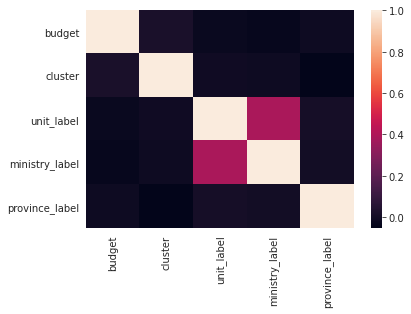

In [ ]:
sns.heatmap(df_for_cluster.corr());

In [ ]:
df_for_cluster.unit.value_counts()

กรมส่งเสริมการปกครองท้องถิ่น                         39455
กรมส่งเสริมวัฒนธรรม                                     10
กรมอุทยานแห่งชาติ สัตว์ป่า และพันธุ์พืช                  9
กรมการปกครอง                                             7
กรมป่าไม้                                                6
กรมทรัพยากรน้ำบาดาล                                      6
กรมทรัพยากรน้ำ                                           6
กรมทางหลวงชนบท                                           5
กรมทางหลวง                                               5
กรมการท่องเที่ยว                                         2
สำนักงานปลัดกระทรวงมหาดไทย                               1
สำนักงานปลัดกระทรวงเกษตรและสหกรณ์                        1
กรมควบคุมมลพิษ                                           1
กระทรวงการอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม         1
กระทรวงศึกษาธิการ                                        1
สำนักงานปลัดกระทรวงทรัพยากรธรรมชาติและสิ่งแวดล้อม        1
สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา                 

In [ ]:
df_for_cluster.ministry.value_counts()

มหาดไทย                                      39474
ทรัพยากรธรรมชาติและสิ่งแวดล้อม                  29
คมนาคม                                          10
การท่องเที่ยวและกีฬา                             3
การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม        1
สำนักงานตำรวจแห่งชาติ                            1
ศึกษาธิการ                                       1
เกษตรและสหกรณ์                                   1
Name: ministry, dtype: int64

In [ ]:
df_for_cluster.province.value_counts()

ขอนแก่น        3426
กาฬสินธุ์      2112
มหาสารคาม      1757
มุกดาหาร       1587
สกลนคร         1582
               ... 
สมุทรปราการ      56
ราชบุรี          38
อุบลราชธานี      13
หนองบัวลำภู       6
พะเยา             1
Name: province, Length: 66, dtype: int64

In [ ]:
df_for_cluster.cluster.value_counts()

1    24214
0    13285
2     2021
Name: cluster, dtype: int64

##  3.2 Explore Number of Project and Project Budget



In [ ]:
print('มีจำนวนโครงการทั้งหมด ', len(df_for_cluster), ' โครงการ')

มีจำนวนโครงการทั้งหมด  39522  โครงการ


In [ ]:
maxProj = df_for_cluster.loc[df_for_cluster['budget'].idxmax()]
minProj = df_for_cluster.loc[df_for_cluster['budget'].idxmin()]

In [ ]:
print('โครงการที่ของบประมาณมากที่สุดคือ ', maxProj['project_name_ori'] ,'มูลค่า ', maxProj['budget'],' บาท ', 'จังหวัด', maxProj['province'])
print('โครงการที่ของบประมาณน้อยที่สุดคือ ', minProj['project_name_ori'] ,'มูลค่า ', minProj['budget'],' บาท ', 'จังหวัด', minProj['province'])

โครงการที่ของบประมาณมากที่สุดคือ  โครงการด้านโครงสร้างพื้นฐาน มูลค่า  3200828831.1  บาท  จังหวัด ขอนแก่น
โครงการที่ของบประมาณน้อยที่สุดคือ  โครงการขุดสระเก็บน้ำบ้านหมอแปง หมู่ที่ 4 ขุดดินด้วยเครื่องจักร กว้าง 6 .00 ม. ยาว 6.00 ม. ลึกเฉลี่ย 2.00 ม. หรือปริมาณดินขุดไม่น้อยกว่า 136 ลบ.ม. มูลค่า  8700.0  บาท  จังหวัด แม่ฮ่องสอน




> Project Budget Digit



In [ ]:
df_for_cluster['digits'] = df_for_cluster.budget.map(lambda x: len(str(round(x))) if x==x else x)
dg = df_for_cluster.groupby(['digits']).project_name_ori.count().sort_values(ascending = False).reset_index()
dg

,digits,project_name_ori
0,6,22824
1,7,14012
2,8,2197
3,5,354
4,9,126
5,10,6
6,4,1


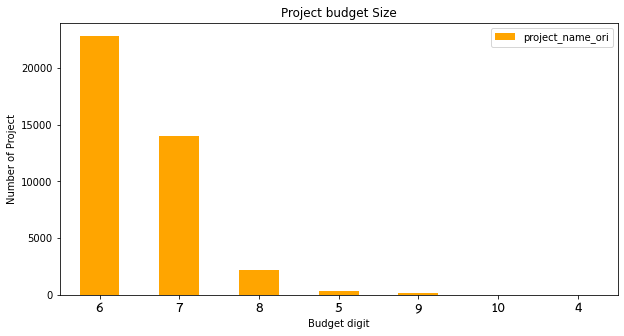

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=20)
from matplotlib import rcParams


plt.rcParams["figure.figsize"] = (10,5)
#plot.figure(figsize=(50,50))
ax = dg.plot.bar(x='digits', y='project_name_ori', title="Project budget Size",color="orange")
ax.set_xticklabels(dg['digits'], FontProperties=font,rotation=0)
plt.xlabel('Budget digit')
plt.ylabel('Number of Project')
plt.show();

In [ ]:
df_for_cluster.head(2)

,Project_name,unit,ministry,budget,province,TOKEN,project_name_remove_stopword,cluster,project_name_ori,eng_province,digits
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,"['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",1,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,Krabi,6
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,"['พัฒนา', 'ศักยภาพ', 'เสริมสร้าง', 'ความเข้มแข...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,Krabi,6




> Project Budget Digits by Province



In [ ]:
digit_10 = df_for_cluster[df_for_cluster['digits'] == 10]
digit_10_g = digit_10.groupby('province')['province'].size().sort_values(ascending = False)
digit_10_g = pd.DataFrame(digit_10_g)
digit_10_g = digit_10_g.rename({'province': 'count'}, axis=1)
digit_10_g = digit_10_g.reset_index()

digit_9 = df_for_cluster[df_for_cluster['digits'] == 9]
digit_9_g = digit_9.groupby('province')['province'].size().sort_values(ascending = False)
digit_9_g = pd.DataFrame(digit_9_g)
digit_9_g = digit_9_g.rename({'province': 'count'}, axis=1)
digit_9_g = digit_9_g.reset_index()
#digit_9_g


Text(0, 0.5, 'Number of Project')

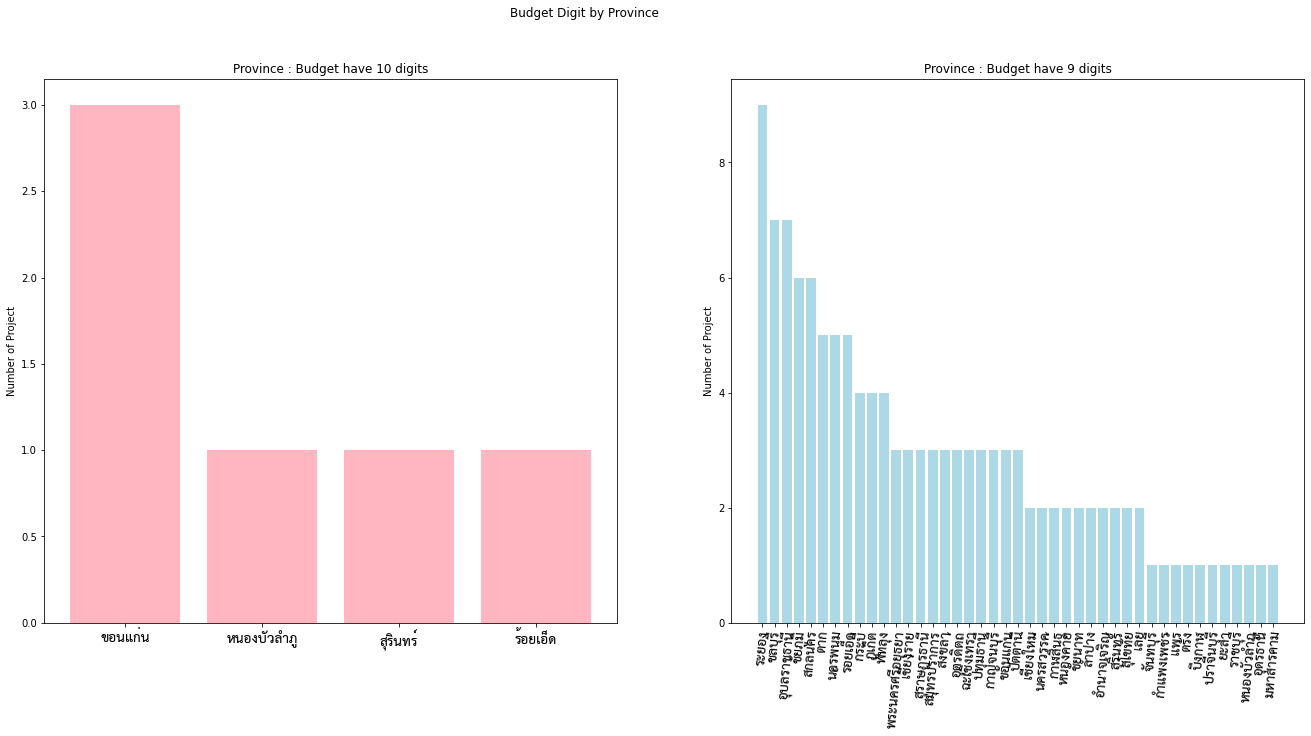

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=20)
import matplotlib.pyplot as plot
from matplotlib import rcParams

plot.rcParams["figure.figsize"] = (20,10)
fig, axs = plot.subplots(1,2)
#fig.tight_layout()
fig.suptitle('Budget Digit by Province')

axs[0].bar(digit_10_g['province'], digit_10_g['count'], color = 'lightpink')
axs[0].set_xticklabels(digit_10_g['province'], FontProperties=font)
axs[0].set_title('Province : Budget have 10 digits')
axs[0].set_ylabel('Number of Project')
fig.subplots_adjust(right=1)



axs[1].bar(digit_9_g['province'], digit_9_g['count'], color = 'lightblue')
axs[1].set_xticklabels(digit_9_g['province'], FontProperties=font, rotation=85 )
axs[1].set_title('Province : Budget have 9 digits')
axs[1].set_ylabel('Number of Project')

## 3.3 Explore Ministry (กระทรวง) and Unit (หน่วยงาน)



> Ministry (กระทรวง)



In [ ]:
ministry_g = df_for_cluster.groupby('ministry')['ministry'].count().sort_values(ascending=False)
ministry_g = pd.DataFrame(ministry_g)
ministry_g = ministry_g.rename({'ministry': 'count'}, axis=1)
ministry_g = ministry_g.reset_index()
#ministry_g.head(5)

ministry_bg = df_for_cluster.groupby(['ministry'])['budget'].sum().sort_values(ascending=False)
ministry_bg = pd.DataFrame(ministry_bg)
ministry_bg = ministry_bg.rename({'budget': 'b'}, axis=1)
ministry_bg['budget(M)'] = ministry_bg['b']/1000000
ministry_bg.drop(['b'], axis=1, inplace=True)
ministry_bg = ministry_bg.reset_index()
ministry_bg

,ministry,budget(M)
0,มหาดไทย,154161.896762
1,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,934.697475
2,คมนาคม,490.799000
3,การท่องเที่ยวและกีฬา,66.497871
4,การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,50.000000
5,สำนักงานตำรวจแห่งชาติ,2.264000
6,เกษตรและสหกรณ์,1.595000
7,ศึกษาธิการ,0.496000


Text(0, 0.5, 'Million (Baht)')

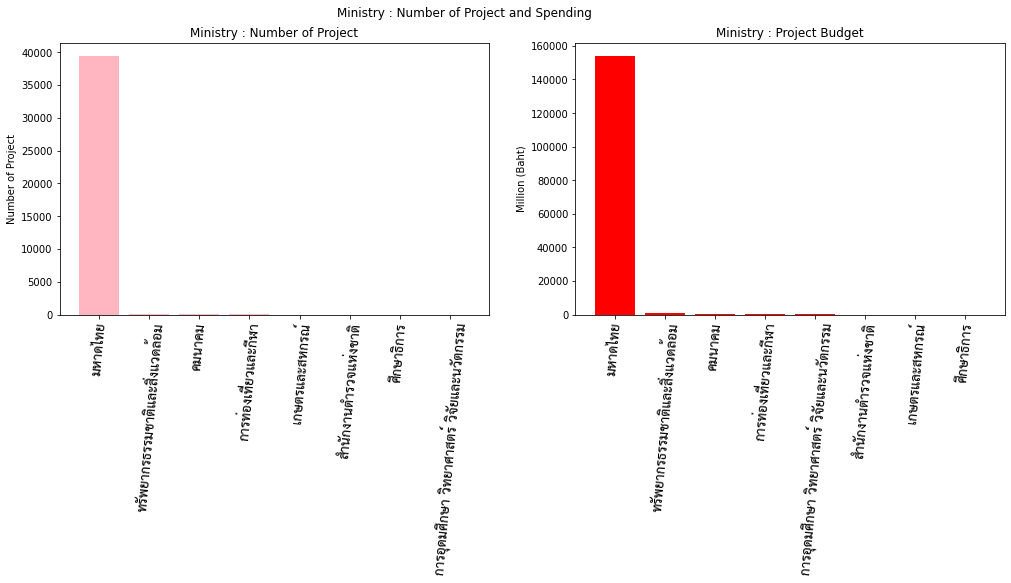

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=20)
import matplotlib.pyplot as plot
from matplotlib import rcParams

plot.rcParams["figure.figsize"] = (15,5)
fig, axs = plot.subplots(1,2)
#fig.tight_layout()
fig.suptitle('Ministry : Number of Project and Spending')

axs[0].bar(ministry_g['ministry'], ministry_g['count'], color = 'lightpink')
axs[0].set_xticklabels(ministry_g['ministry'], FontProperties=font, rotation=85)
axs[0].set_title('Ministry : Number of Project')
axs[0].set_ylabel('Number of Project')
fig.subplots_adjust(right=1)



axs[1].bar(ministry_bg['ministry'], ministry_bg['budget(M)'], color = 'red')
axs[1].set_xticklabels(ministry_bg['ministry'], FontProperties=font , rotation=85)
axs[1].set_title('Ministry : Project Budget')
axs[1].set_ylabel('Million (Baht)')

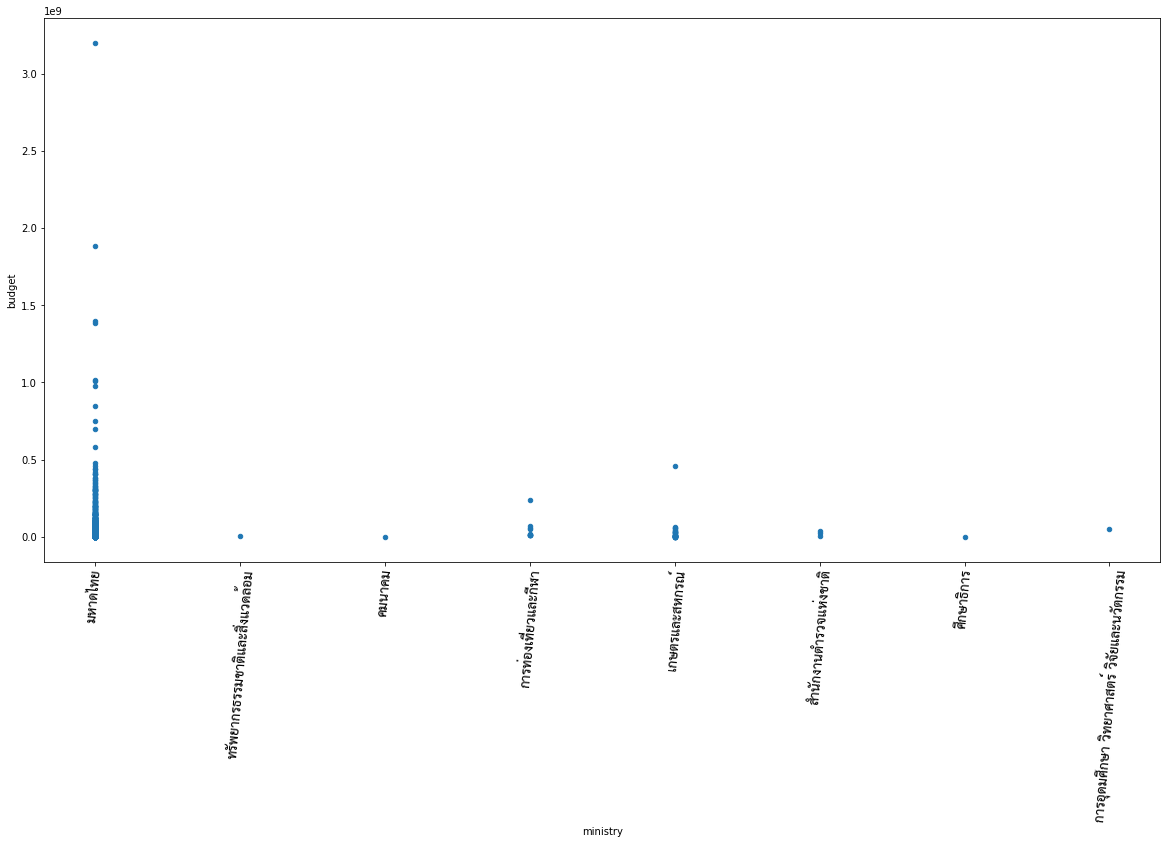

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=20)
import matplotlib.pyplot as plot
from matplotlib import rcParams

plot.rcParams["figure.figsize"] = (20,10)

ax = df_for_cluster.plot.scatter(x= 'ministry', y='budget')
ax.set_xticklabels(ministry_g['ministry'], FontProperties=font, rotation=85)
plot.show()





> Unit (หน่วยงาน)



In [ ]:
unit_g = df_for_cluster.groupby('unit')['unit'].count().sort_values(ascending=False)
unit_g = pd.DataFrame(unit_g)
unit_g = unit_g.rename({'unit': 'count'}, axis=1)
unit_g = unit_g.reset_index()
#unit_g.head(5)

unit_bg = df_for_cluster.groupby(['unit'])['budget'].sum().sort_values(ascending=False)
unit_bg = pd.DataFrame(unit_bg)
unit_bg = unit_bg.rename({'budget': 'b'}, axis=1)
unit_bg['budget(M)'] = unit_bg['b']/1000000
unit_bg.drop(['b'], axis=1, inplace=True)
unit_bg = unit_bg.reset_index()
unit_bg.head(10)

,unit,budget(M)
0,กรมส่งเสริมการปกครองท้องถิ่น,154030.435762
1,กรมทรัพยากรน้ำบาดาล,573.497200
2,กรมทางหลวงชนบท,330.799000
3,กรมทรัพยากรน้ำ,211.280600
4,กรมทางหลวง,160.000000
5,กรมส่งเสริมวัฒนธรรม,100.349000
6,กรมอุทยานแห่งชาติ สัตว์ป่า และพันธุ์พืช,86.140200
7,กรมการท่องเที่ยว,59.997871
8,กระทรวงการอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,50.000000
9,กรมป่าไม้,34.586100


Text(0, 0.5, 'Million (Baht)')

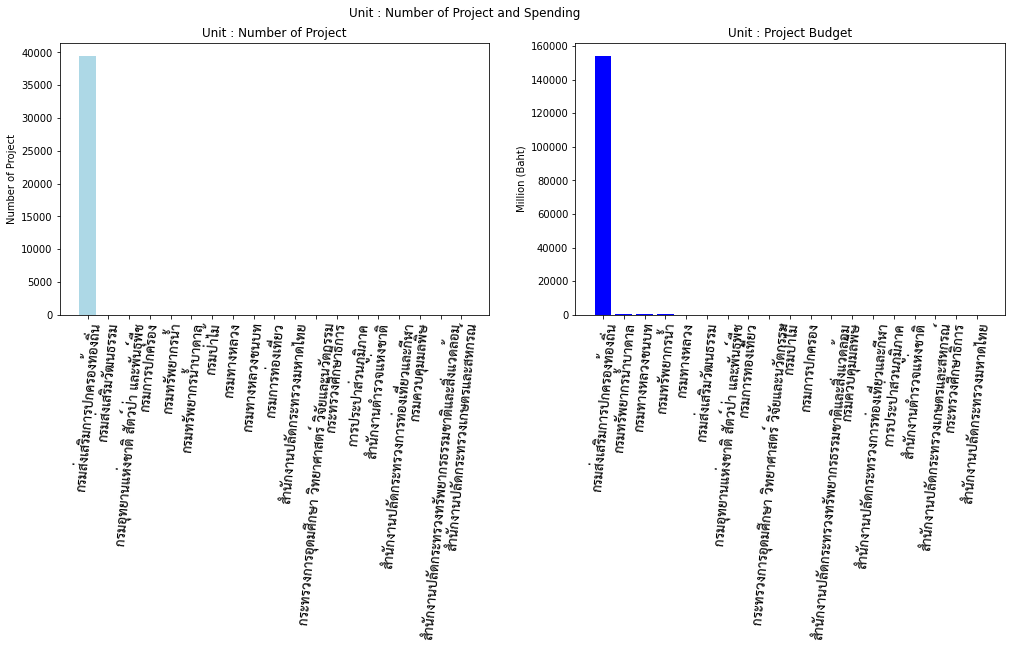

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=20)
import matplotlib.pyplot as plot
from matplotlib import rcParams

plot.rcParams["figure.figsize"] = (15,5)
fig, axs = plot.subplots(1,2)
#fig.tight_layout()
fig.suptitle('Unit : Number of Project and Spending')

axs[0].bar(unit_g['unit'], unit_g['count'], color = 'lightblue')
axs[0].set_xticklabels(unit_g['unit'], FontProperties=font, rotation=85)
axs[0].set_title('Unit : Number of Project')
axs[0].set_ylabel('Number of Project')
fig.subplots_adjust(right=1)



axs[1].bar(unit_bg['unit'], unit_bg['budget(M)'], color = 'blue')
axs[1].set_xticklabels(unit_bg['unit'], FontProperties=font , rotation=85)
axs[1].set_title('Unit : Project Budget')
axs[1].set_ylabel('Million (Baht)')

## 3.4 Explore Province

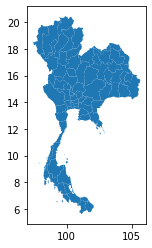

In [ ]:
gdf = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/IS/insight/etc/Thailand.json')
gdf.columns = ['Province','geometry']

gdf.plot()
plt.show()

In [ ]:
gdf

,Province,geometry
0,Mae Hong Son,"POLYGON ((98.08593 19.77316, 98.11135 19.77714..."
1,Chumphon,"POLYGON ((99.27258 10.95801, 99.27754 10.95902..."
2,Nakhon Si Thammarat,"POLYGON ((100.34246 7.93878, 100.33778 7.93789..."
3,Phuket,"POLYGON ((98.41863 7.90375, 98.42189 7.90843, ..."
4,Phangnga,"MULTIPOLYGON (((98.53631 8.11514, 98.54054 8.1..."
...,...,...
72,Nakhon Phanom,"POLYGON ((104.28198 17.86149, 104.28757 17.856..."
73,Mukdahan,"POLYGON ((104.30405 16.85308, 104.31676 16.857..."
74,Narathiwat,"POLYGON ((101.72075 6.57337, 101.72350 6.57438..."
75,Pattani,"POLYGON ((101.72350 6.57438, 101.72075 6.57337..."


In [ ]:
provGroup = df_for_cluster.groupby(['eng_province'])['eng_province'].count().sort_values(ascending=False)
provGroup = pd.DataFrame(provGroup)
provGroup = provGroup.rename({'eng_province': 'count'}, axis=1)
provGroup = provGroup.reset_index()
provGroup


df_merge_gdf1 = pd.merge(provGroup, gdf, how='left', left_on='eng_province', right_on='Province')
#df_merge_gdf1.head(5)
provGroup.head(5)

,eng_province,count
0,Khon Kaen,3426
1,Kalasin,2112
2,Maha Sarakham,1757
3,Mukdahan,1587
4,Sakon Nakhon,1582


In [ ]:
variable = df_merge_gdf1['count']
vmin = min(df_merge_gdf1['count'])
vmax = max(df_merge_gdf1['count'])

from geopandas import GeoDataFrame
df_merge_gdf1 = GeoDataFrame(df_merge_gdf1)

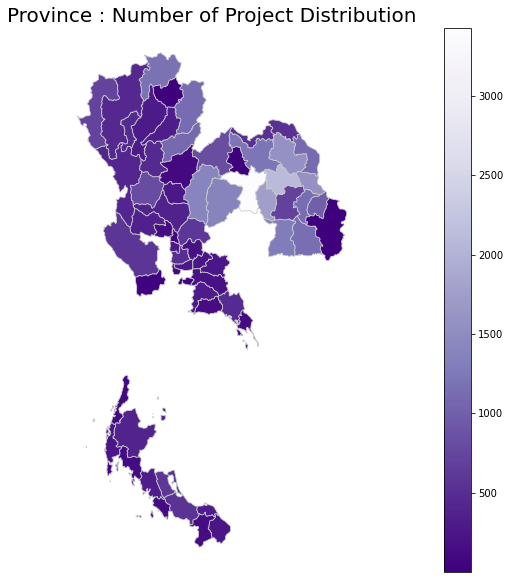

In [ ]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Province : Number of Project Distribution', fontdict={'fontsize': '20', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Purples_r',norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
fig.colorbar(sm)
df_merge_gdf1.plot(column=variable, cmap='Purples_r', linewidth=0.8, ax=ax, edgecolor='0.8')

In [ ]:
province_bg = df_for_cluster.groupby(['eng_province'])['budget'].sum().sort_values(ascending=False)
province_bg = pd.DataFrame(province_bg)
province_bg = province_bg.rename({'budget': 'b'}, axis=1)
province_bg['budget(M)'] = province_bg['b']/1000000
province_bg.drop(['b'], axis=1, inplace=True)
province_bg = province_bg.reset_index()


df_merge_gdf = pd.merge(province_bg, gdf, how='left', left_on='eng_province', right_on='Province')
df_merge_gdf.head(5)

,eng_province,budget(M),Province,geometry
0,Khon Kaen,11544.988263,Khon Kaen,"POLYGON ((102.84466 16.87372, 102.86342 16.877..."
1,Roi Et,8036.436000,Roi Et,"POLYGON ((104.35588 16.32340, 104.32782 16.260..."
2,Kalasin,6072.659084,Kalasin,"POLYGON ((103.65014 17.04387, 103.64735 17.037..."
3,Surin,6072.162390,Surin,"POLYGON ((103.34323 15.40172, 103.36044 15.404..."
4,Chaiyaphum,4872.680900,Chaiyaphum,"POLYGON ((101.63321 16.68340, 101.63724 16.683..."


In [ ]:
variable = df_merge_gdf['budget(M)']
vmin = min(df_merge_gdf['budget(M)'])
vmax = max(df_merge_gdf['budget(M)'])

from geopandas import GeoDataFrame
df_merge_gdf = GeoDataFrame(df_merge_gdf)

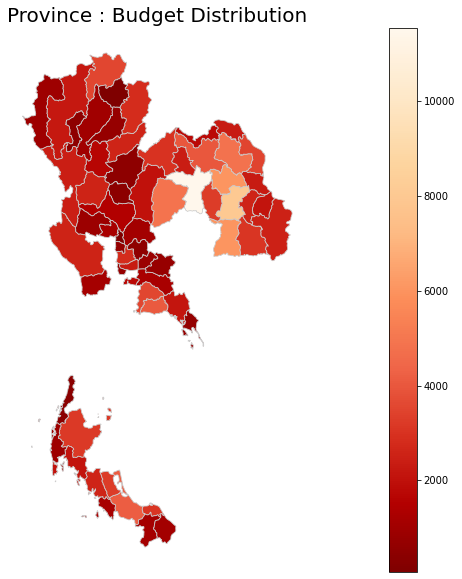

In [ ]:
fig, ax = plt.subplots(1, figsize=(30, 10))
ax.axis('off')
ax.set_title('Province : Budget Distribution', fontdict={'fontsize': '20', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='OrRd_r',norm=plt.Normalize(vmax=vmax, vmin=vmin))
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
fig.colorbar(sm)
df_merge_gdf.plot(column=variable, cmap='OrRd_r', linewidth=0.8, ax=ax, edgecolor='0.8')

จำนวนประชากร หรือขนาดพื้นที่กับงบประมาณ

## 3.5 Explore Project Duplicate (โครงการที่มีการขอซ้ำ)



> แสดงจำนวนโครงการที่มีการขอเข้ามาซ้ำๆ โดยเป็นชื่อโครงการเดียวกัน จังหวัดเดียวกัน และขอด้วยงบประมาณที่เท่ากัน



In [ ]:
dupProj = df_for_cluster.groupby(['project_name_ori','budget', 'province']).size().sort_values(ascending = False)
dupProj = dupProj.reset_index()
#dupProj['count'] = dupProj[0]
dupProj = dupProj.rename({0: 'count'}, axis=1)
dupProj.head(10)

,project_name_ori,budget,province,count
0,ขุดสระน้ำ ขนาดกว้าง 20 ม. ยาว 40 ม. ลึกเฉลี่ย ...,134000.0,มหาสารคาม,233
1,โครงการพัฒนาระบบการคมนาคมขนส่งและการท่องเที่ยว,500000.0,หนองคาย,146
2,โครงการพัฒนาและปรับปรุงเส้นทางคมนาคมชุมชนและไฟ...,500000.0,บึงกาฬ,124
3,ขุดเจาะบ่อบาดาลพลังงานแสงอาทิตย์ กลุ่มพลังงานแ...,500000.0,มหาสารคาม,103
4,โครงการพัฒนาโครงสร้างพื้นฐานด้านการเกษตร,800000.0,หนองคาย,102
5,ขุดเจาะน้ำบาดาลพลังงานแสงอาทิตย์ กลุ่ม,500000.0,มหาสารคาม,26
6,โครงการพัฒนาโครงสร้างพื้นฐานด้านการเกษตร,500000.0,หนองคาย,17
7,โครงสร้างพื้นฐานของชุมชน,500000.0,สกลนคร,16
8,โครงการพัฒนาโครงสร้างเส้นทางขนส่งผลผลิตทางการเ...,500000.0,สกลนคร,15
9,โครงการจัดซื้อรถยนต์บรรทุกสำหรับย่อยกิ่งไม้ จำ...,7500000.0,บึงกาฬ,14




> แสดงจังหวัดที่มีการขอโครงการซ้ำมากที่สุดตามลำดับ



In [ ]:
Projdup = dupProj.groupby(['province']).size().sort_values(ascending = False)
Projdup = Projdup.reset_index()
Projdup = Projdup.rename({0: 'count'}, axis=1)
#Projdup

Text(0, 0.5, 'Count')

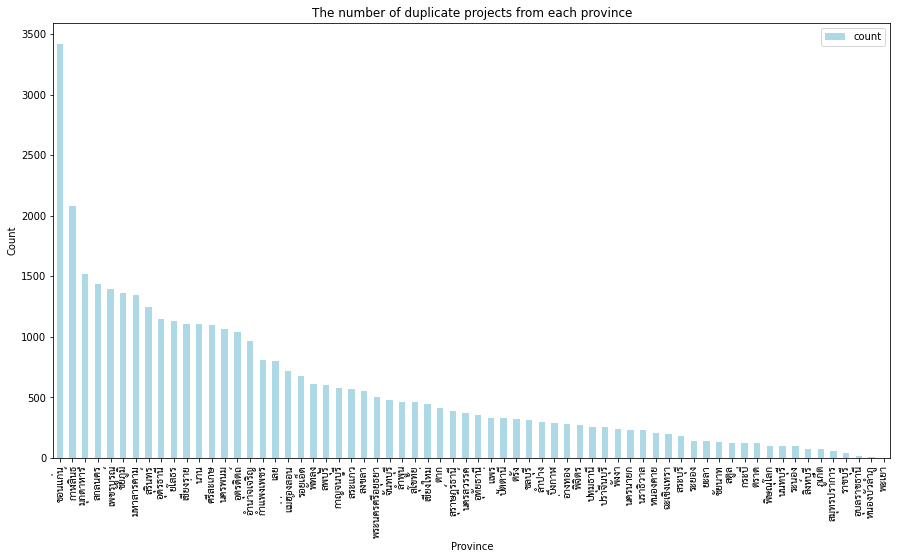

In [ ]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=15)
import matplotlib.pyplot as plot
from matplotlib import rcParams

plot.rcParams["figure.figsize"] = (15,8)
#fig, axs = plot.subplots(2)
#ax.subtitle('The number of duplicate projects from each province')
ax = Projdup.plot.bar(x = 'province', y='count', color = 'lightblue',  title="The number of duplicate projects from each province")
ax.set_xticklabels(Projdup['province'], FontProperties=font)
plot.xlabel('Province')
plot.ylabel('Count')


#4. Data Tokenized and TFIDF

In [ ]:
stopword = ['กว้าง',  'เมตร', 'ยาว', 'หนา', 'จำนวน', 'สข ถ', ' ม ', 'ตรม','ขวา', 'หนาเฉลี่ย', 'อย ถ', 
            'ซอย', 'ถึง','ตารางเมตร','ลบ','ตร','กม','จังหวัด','เขต','อำเภอ','ตำบล','หมู่','บ้าน','เมือง', 
            'หมู่ที่','หมู่บ้าน','หนอง','ขนาด','ปริมาณ','ขนาดกว้าง','หรือมีพื้นทีไม่น้อยกว่า', ' อ ', ' ต ', ' จ ', 
            'แห่ง', 'ลบ ม', 'นิ้ว', 'Ø', 'กิโลเมตร','ลูกบาศก์เมตร','ลึกเฉลี่ย', 'รหัส', 'ความยาว', 'ชั่วโมง', 
            'ลึก',' บ ', 'แห่ง', 'ซม', 'สาย', 'ชุมชน', 'เฉลี่ย','โดยรวม','พื้นที่', 'ยโสธร', 'พระนครศรีอยุธยา',
            'แก้ว', 'เลิง', 'หมี', 'แซง', 'มิ่ง', 'สามัคคี','ดอน', 'เจริญ', ' ป่า']#, 'ทุ่ง', 'โนน', 'โคก', 'พระ']
            #'ชัย', 'มูล', 'ไทย', 'ศรี', 'มหา','โพน','กุด']

In [ ]:
stop_word_list = pythainlp.corpus.common.thai_stopwords() 

In [ ]:
token_list=[]
for proj in df_thaime['project_name_clean']:
  #stop_word_list = pythainlp.corpus.common.thai_stopwords() 
  word_list =  pythainlp.corpus.thai_words()
  token_proj = word_tokenize(proj, engine="newmm") 
  token_clean = [token for token in token_proj if (token not in stop_word_list)
                                                                      and (token not in stopword)
                                                                      and (' ' not in token)
                                                                      and (token in word_list)
                                                                      and len(token) > 2]
  #print(token)                                                        
  token_list.append(list(token_clean))
print(token_list[:10])

[['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน', 'ตัด', 'หญ้า'], ['พัฒนา', 'ศักยภาพ', 'เสริมสร้าง', 'ความเข้มแข็ง', 'ยั่งยืน'], ['ศูนย์', 'สั่งการ', 'ความปลอดภัย', 'เชิง', 'บูรณ'], ['เพิ่มประสิทธิภาพ', 'ดูแลรักษา', 'ความสะอาด', 'ชายหาด', 'รองรับ', 'การท่องเที่ยว', 'คุณภาพ'], ['ก่อสร้าง', 'ถนน', 'ติก', 'คอนกรีต', 'ชั้น', 'พื้น', 'ดิน', 'ซีเมนต์', 'ปรับปรุง', 'คุณภาพ', 'ยาง', 'ธรรมชาติ', 'พรุ', 'ท่าเรือ', 'อ่าว', 'อ่าว', 'กระบี่'], ['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยาง', 'พารา', 'ติก', 'คอนกรีต', 'ชั้น', 'พื้น', 'ดิน', 'ซีเมนต์', 'ปรับปรุง', 'คุณภาพ', 'ยาง', 'ธรรมชาติ', 'ห้วย', 'ห้วย', 'พรุ', 'ห้วย', 'ห้วย', 'พลู', 'หนัง'], ['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยาง', 'พารา', 'ติก', 'คอนกรีต', 'ชั้น', 'พื้น', 'ดิน', 'ซีเมนต์', 'ปรับปรุง', 'คุณภาพ', 'ยาง', 'ธรรมชาติ', 'ท้าย', 'ทรายขาว'], ['ซ่อม', 'สร้าง', 'ถนน', 'ผิวจราจร', 'คอนกรีต', 'ชั้น', 'พื้น', 'ดิน', 'ซีเมนต์', 'ปรับปรุง', 'คุณภาพ', 'ยาง', 'ธรรมชาติ', 'พรุ', 'ดิน', 'คลอง', 'ชะมวง', 'พรุ', 'ดิน', 'คลอง', 'ท่อม', 'กระ

In [ ]:
desc = df_thaime['project_name_clean'].values
desc

array(['ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า  ',
       'พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอย่างยั่งยืน  ',
       'ศูนย์สั่งการความปลอดภัยเชิงบูรณการ  ', ...,
       'ปรับปรุงผิวถนนคอนกรีตเสริมเหล็ก  เป็นผิวลาดยางแอฟัลท์ติกคอนกรีตผิวจราจรหมู่ที่   ',
       'ปรับปรุงผิวจราจรถนนปูแอสฟัลส์ติกคอนกรีต  หมู่ที่  ตำบลลำตะเคียน  อำเภอผักไห่  จังหวัดพระนครศรีอยุธยา  ',
       'ปรับปรุงซ่อมแซมถนนคอนกรีตเสริมเหล็ก ถนนสายบ้านช้าง   วัดเวียง หมู่ที่  ตำบลท่าหลวง อำเภอท่าเรือ จังหวัดพระนครศรีอยุธยา ถนนคอนกรีตเสริมเหล็ก  หนา   เมตร กว้างเฉลี่ย       เมตร ยาวโดยรวม   เมตร หรือมีพื้นที่ก่อสร้างโดยรวมไม่น้อยกว่า    ตารางเมตร  '],
      dtype=object)

In [ ]:
df_for_cluster = {'Project_name':df_thaime['project_name_clean'],
                  'Project_name_Original' :df_thaime['project_name'],
                  'unit' : df_thaime['unit'],
                  'ministry' : df_thaime['ministry'],
                  'budget' : df_thaime['budget'],
                  'province' : df_thaime['province'],
                  'Eng_province': df_thaime['ENG_province'],
                  'TOKEN': token_list}
df_for_cluster = pd.DataFrame(df_for_cluster)
df_for_cluster.head(5)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ..."
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่..."
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,200000000.0,กระบี่,Krabi,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]"
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,15000000.0,กระบี่,Krabi,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา..."
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,..."


In [ ]:
type(df_for_cluster['TOKEN'][0])

list

In [ ]:
proj = [','.join(i) for i in df_for_cluster['TOKEN']]
df_for_cluster['project_name_remove_stopword'] = proj
df_for_cluster.head(5)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า"
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน"
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,200000000.0,กระบี่,Krabi,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]","ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ"
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,15000000.0,กระบี่,Krabi,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา...","เพิ่มประสิทธิภาพ,ดูแลรักษา,ความสะอาด,ชายหาด,รอ..."
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์..."


In [ ]:
v = df_for_cluster['project_name_remove_stopword'].values
v

array(['ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า',
       'พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน',
       'ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ', ...,
       'ปรับปรุง,ผิวถนน,คอนกรีตเสริมเหล็ก,ผิว,ลาดยาง,ติก,คอนกรีต,ผิวจราจร',
       'ปรับปรุง,ผิวจราจร,ถนน,ติก,คอนกรีต,ตะเคียน,ผักไห่',
       'ปรับปรุง,ซ่อมแซม,ถนน,คอนกรีตเสริมเหล็ก,ถนน,ช้าง,วัด,เวียง,ท่า,หลวง,ท่าเรือ,ถนน,คอนกรีตเสริมเหล็ก,ก่อสร้าง'],
      dtype=object)

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
X = vectorizer.fit_transform(v)
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tf_idf = vectorizer.idf_

In [ ]:
features = vectorizer.get_feature_names()
print(len(features))
print(features[:50]) 

4637
['กก', 'กกรง', 'กกระเฉด', 'กกะ', 'กกา', 'กกาด', 'กการะ', 'กกำพร', 'กข', 'กขชาต', 'กขม', 'กขวง', 'กขา', 'กค', 'กงจ', 'กงบประมาณ', 'กงาน', 'กงานเขต', 'กงเกว', 'กจ', 'กช', 'กซ', 'กฐ', 'กด', 'กดา', 'กดาหาร', 'กดำบรรพ', 'กต', 'กตบชวา', 'กตร', 'กตา', 'กท', 'กทม', 'กทรอน', 'กทอง', 'กน', 'กนก', 'กนายกร', 'กบ', 'กบนา', 'กบอล', 'กบาตร', 'กบาน', 'กบาศก', 'กป', 'กปลา', 'กปอด', 'กผ', 'กผสม', 'กพระ']


In [ ]:
tf = dict(zip(features, tf_idf))
print(tf)

{'กก': 10.198343698791998, 'กกรง': 10.891490879351943, 'กกระเฉด': 10.891490879351943, 'กกะ': 10.891490879351943, 'กกา': 10.891490879351943, 'กกาด': 9.638727910856575, 'กการะ': 10.891490879351943, 'กกำพร': 10.891490879351943, 'กข': 10.198343698791998, 'กขชาต': 10.891490879351943, 'กขม': 10.198343698791998, 'กขวง': 10.198343698791998, 'กขา': 10.891490879351943, 'กค': 10.891490879351943, 'กงจ': 10.891490879351943, 'กงบประมาณ': 7.871065993207582, 'กงาน': 7.490293497689788, 'กงานเขต': 10.891490879351943, 'กงเกว': 10.891490879351943, 'กจ': 8.94558073029663, 'กช': 8.640199080745449, 'กซ': 10.891490879351943, 'กฐ': 9.97520014747779, 'กด': 6.391681209021679, 'กดา': 9.38741348257567, 'กดาหาร': 9.38741348257567, 'กดำบรรพ': 10.48602577124378, 'กต': 10.48602577124378, 'กตบชวา': 7.9210764137822425, 'กตร': 10.891490879351943, 'กตา': 10.891490879351943, 'กท': 7.595654013347615, 'กทม': 10.48602577124378, 'กทรอน': 9.792878590683834, 'กทอง': 9.792878590683834, 'กน': 8.406584229563943, 'กนก': 8.0292899984

In [ ]:
test = {'Project_Name': df_for_cluster['Project_name_Original'],
        'TOKEN': df_for_cluster['TOKEN']}
test = pd.DataFrame(test)
test.head()

,Project_Name,TOKEN
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ..."
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่..."
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]"
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา..."
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,..."


# 5. Project Clustering (K-Means)

37786.58292559735
36354.81601797545
35272.63433467753
34764.78832962911
34382.33014769212
33972.810392332656
33628.23237874441
33423.21600050383
33192.03424322966
32936.51823097604
32773.65652444868
32537.682855821706
32376.80807235878
32158.221014869472


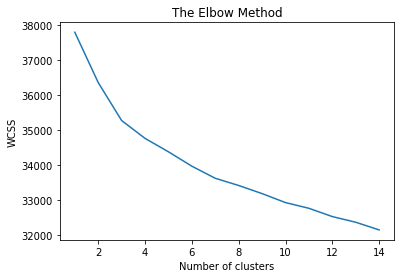

In [ ]:
from sklearn.cluster import KMeans
wcss1 = []

for i in range(1,15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    #kmeans = KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(X)
    print(kmeans.inertia_)
    wcss1.append(kmeans.inertia_)
plt.plot(range(1,15),wcss1)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
#plt.savefig('elbow.png')
plt.show()

In [ ]:
k = 3
model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10,random_state=42)

model.fit(X)
model.fit(X)
labels=model.labels_
df_for_cluster['cluster'] = labels
#df_cluster =pd.DataFrame(list(zip(df_token['TOKEN'],labels)),columns=['title','cluster'])
#print(df_token.sort_values(by=['cluster']))
df_for_cluster.head(5)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",0
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",0
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,200000000.0,กระบี่,Krabi,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]","ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ",0
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,15000000.0,กระบี่,Krabi,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา...","เพิ่มประสิทธิภาพ,ดูแลรักษา,ความสะอาด,ชายหาด,รอ...",0
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...",0


In [ ]:
g = df_for_cluster.groupby(['cluster'])['cluster'].count().sort_values()
g

cluster
2     2021
1    13194
0    24307
Name: cluster, dtype: int64

In [ ]:
token=[]
import ast
for i in range(len(df_for_cluster)):
  x = df_for_cluster.loc[i, 'TOKEN']
  x = ast.literal_eval(x)
  token.append(x)

#token
df_for_cluster['TOKEN_N'] = token
df_for_cluster.head()

ValueError: ignored

In [ ]:
df_cluster_0 = df_for_cluster[df_for_cluster['cluster'] == 0]
df_cluster_1 = df_for_cluster[df_for_cluster['cluster'] == 1]
df_cluster_2 = df_for_cluster[df_for_cluster['cluster'] == 2]

In [ ]:
print(len(df_cluster_0))
df_cluster_0['project_name_remove_stopword'].head(10)

24307


0         ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า
1        พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน
2                  ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ
3    เพิ่มประสิทธิภาพ,ดูแลรักษา,ความสะอาด,ชายหาด,รอ...
4    ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...
5    ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...
6    ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...
7    ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...
8    ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...
9     ติดตั้ง,กล้องวงจรปิด,บริเวณ,ที่สาธารณะ,ศาลา,ด่าน
Name: project_name_remove_stopword, dtype: object

In [ ]:
print(len(df_cluster_1))
df_cluster_1['project_name_remove_stopword'].head(10)

13194


38    ก่อสร้าง,รั้ว,คอนกรีตเสริมเหล็ก,ศูนย์,พัฒนา,เด...
49    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,บ้านใหญ่,วัด,โพ...
56    ปรับปรุง,ผิวจราจร,คอนกรีตเสริมเหล็ก,ผิวจราจร,พ...
57     ก่อสร้าง,ถนนลาดยาง,พารา,คอนกรีต,รอบ,อ่าง,น้ำ,บ่อ
61    ก่อสร้าง,ถนน,ผิวจราจร,พารา,ติก,คอนกรีต,ถนน,ถนน...
62    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,ฉาย,คลอง,มัง,หน...
65         ก่อสร้าง,ถนนลาดยาง,ติก,คอนกรีต,คลอง,ทุ่ง,ค้อ
66    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,คีรี,ปลาย,พระยา...
67    ก่อสร้าง,ฝายน้ำล้น,คอนกรีตเสริมเหล็ก,ฝัง,ท่อ,เ...
68    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,ทอง,ชัย,บุรี,หน...
Name: project_name_remove_stopword, dtype: object

In [ ]:
print(len(df_cluster_2))
df_cluster_2['project_name_remove_stopword'].head(10)

2021


424                 พัฒนา,แหล่งน้ำ,อุปโภค,บริโภค,การเกษตร
547        ปรับปรุง,พัฒนา,แหล่งน้ำ,อุปโภค,บริโภค,การเกษตร
566               ขยาย,ประปา,ภูเขา,อุปโภค,บริโภค,การเกษตร
655        ปรับปรุง,พัฒนา,แหล่งน้ำ,อุปโภค,บริโภค,การเกษตร
805              ก่อสร้าง,ประปา,กักเก็บ,น้ำ,อุปโภค,บริโภค
1326       ปรับปรุง,พัฒนา,แหล่งน้ำ,อุปโภค,บริโภค,การเกษตร
1366                พัฒนา,แหล่งน้ำ,อุปโภค,บริโภค,การเกษตร
1372                         พัฒนา,แหล่งน้ำ,อุปโภค,บริโภค
1649    พัฒนา,แหล่งน้ำ,เพิ่มประสิทธิภาพ,การเกษตร,อุปโภ...
1653    พัฒนา,แหล่งน้ำ,เพิ่มประสิทธิภาพ,การเกษตร,อุปโภ...
Name: project_name_remove_stopword, dtype: object

In [ ]:
texts = []
for i in df_cluster_0['TOKEN']:
  for j in i:
    texts.append(j)
#texts
text1 = ''
for i in texts:
  text1 += ' ' + i
#text1

In [ ]:
texts = []
for i in df_cluster_1['TOKEN']:
  for j in i:
    texts.append(j)

text2 = ''
for i in texts:
  text2 += ' ' + i
#text2

In [ ]:
texts = []
for i in df_cluster_2['TOKEN']:
  for j in i:
    texts.append(j)

text3 = ''
for i in texts:
  text3 += ' ' + i
#text2

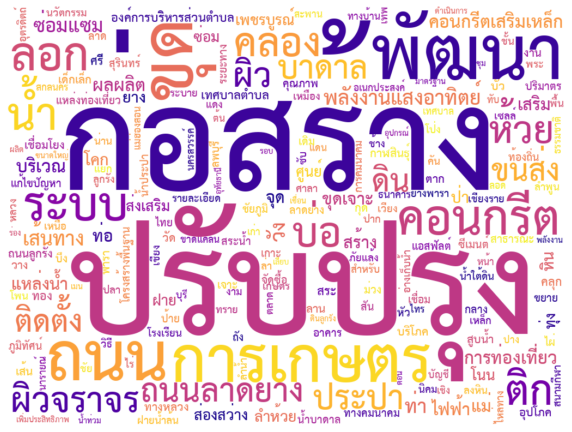

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

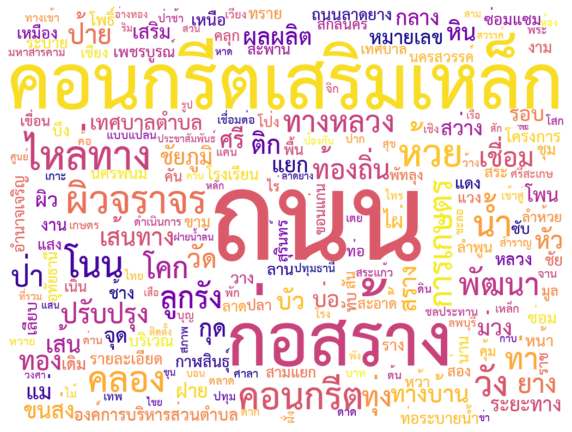

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text2)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

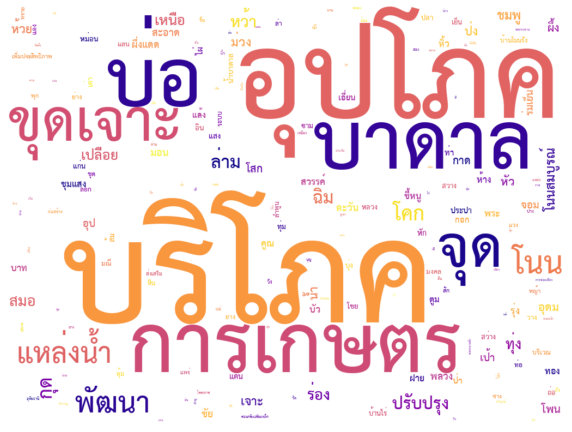

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text3)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

#LDA

In [ ]:
df_for_cluster.head(1)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",0


In [ ]:
import gensim
from gensim.utils import simple_preprocess

In [ ]:
processed_docs = df_for_cluster['TOKEN']

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 การจ้างแรงงาน
1 ตัด
2 รายได้
3 สร้าง
4 ส่งเสริม
5 หญ้า
6 ความเข้มแข็ง
7 พัฒนา
8 ยั่งยืน
9 ศักยภาพ
10 เสริมสร้าง


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(18, 2),
 (27, 1),
 (40, 1),
 (48, 1),
 (80, 2),
 (81, 1),
 (92, 1),
 (132, 1),
 (286, 1),
 (406, 1),
 (541, 2),
 (563, 2),
 (582, 2),
 (1269, 2)]

In [ ]:
[[(dictionary[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]

[[('การจ้างแรงงาน', 1),
  ('รายได้', 1),
  ('สร้าง', 1),
  ('ส่งเสริม', 1),
  ('หญ้า', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.118*"การเกษตร" + 0.102*"จุด" + 0.088*"อุปโภค" + 0.086*"บริโภค" + 0.078*"ทางหลวง" + 0.043*"ท้องถิ่น" + 0.043*"น้ำ" + 0.033*"กลาง" + 0.032*"แคน" + 0.029*"หมายเลข"
Topic: 1 
Words: 0.081*"เสริม" + 0.080*"พัฒนา" + 0.057*"ลาดยาง" + 0.054*"ลาด" + 0.042*"เส้นทาง" + 0.041*"ส่งเสริม" + 0.039*"การเกษตร" + 0.036*"ผสม" + 0.035*"เกษตร" + 0.030*"โครงสร้าง"
Topic: 2 
Words: 0.102*"คอนกรีต" + 0.091*"ปรับปรุง" + 0.078*"กุด" + 0.076*"ติก" + 0.062*"ผิว" + 0.059*"ผิวจราจร" + 0.053*"ถนนลาดยาง" + 0.050*"เทศบาลตำบล" + 0.034*"เขื่อน" + 0.033*"สร้าง"
Topic: 3 
Words: 0.109*"คลอง" + 0.079*"ขุด" + 0.063*"ลอก" + 0.054*"ค้อ" + 0.054*"ดิน" + 0.049*"ศรี" + 0.035*"มหา" + 0.034*"เลียบ" + 0.032*"กึ่ง" + 0.032*"บริเวณ"
Topic: 4 
Words: 0.105*"บ่อ" + 0.099*"บาดาล" + 0.090*"ระบบ" + 0.070*"ประปา" + 0.069*"ขุดเจาะ" + 0.043*"ท่อ" + 0.037*"น้ำ" + 0.036*"ถัง" + 0.032*"ชนะ" + 0.031*"พลังงานแสงอาทิตย์"
Topic: 5 
Words: 0.117*"ทราย" + 0.059*"โรงเรียน" + 0.057*"ทับ" + 0.043*"งาน" + 0.028*"มหาราช" + 0.027*"ภาชี" 

In [ ]:
# Let’s calculate the baseline coherence score
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3456003925775477


In [ ]:
for i,topic in enumerate(lda_model.print_topics(-1)):
    wp = lda_model.show_topic(i)
    topic_keywords = ", ".join([word for word, prop in wp])
    print(f'words for topic #{i}:')
    print(topic_keywords)
    print('\n')


words for topic #0:
คอนกรีต, ติก, ปรับปรุง, ผิว, ผิวจราจร, ถนนลาดยาง, ถนน, ชุม, สร้าง, จุด


words for topic #1:
กุด, การเกษตร, เขื่อน, ขุด, ลอก, น้ำ, ค้อ, พัฒนา, หิน, คลอง


words for topic #2:
เทศบาลตำบล, ปรับปรุง, ระบบ, ประปา, ก่อสร้าง, พัฒนา, น้ำ, ทราย, ไทย, ห้อง


words for topic #3:
คอนกรีตเสริมเหล็ก, ถนน, ก่อสร้าง, บ่อ, บาดาล, ขุดเจาะ, คลอง, โนน, ท่อ, ไหล่ทาง




In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.100*"กุด" + 0.068*"ถนนลาดยาง" + 0.043*"เขื่อน" + 0.043*"สร้าง" + 0.035*"อุปโภค" + 0.034*"บริโภค" + 0.031*"ทางหลวง" + 0.030*"โนน" + 0.028*"เชียง" + 0.018*"ซ่อม"
Topic: 1 
Words: 0.107*"คอนกรีต" + 0.084*"ปรับปรุง" + 0.080*"ติก" + 0.065*"ผิว" + 0.062*"ผิวจราจร" + 0.046*"ถนน" + 0.030*"เสริม" + 0.024*"ค้อ" + 0.023*"พารา" + 0.021*"ลาดยาง"
Topic: 2 
Words: 0.095*"การเกษตร" + 0.085*"พัฒนา" + 0.083*"เทศบาลตำบล" + 0.072*"ชุม" + 0.035*"ห้อง" + 0.032*"ชัย" + 0.028*"เส้นทาง" + 0.027*"ส่งเสริม" + 0.026*"แยก" + 0.022*"ลาน"
Topic: 3 
Words: 0.184*"ก่อสร้าง" + 0.175*"คอนกรีตเสริมเหล็ก" + 0.172*"ถนน" + 0.017*"โนน" + 0.016*"วัด" + 0.014*"ห้วย" + 0.013*"คลอง" + 0.011*"ไหล่ทาง" + 0.011*"ศรี" + 0.010*"ป่า"
Topic: 4 
Words: 0.074*"บ่อ" + 0.070*"บาดาล" + 0.064*"ระบบ" + 0.050*"จุด" + 0.050*"ประปา" + 0.049*"ขุดเจาะ" + 0.041*"น้ำ" + 0.030*"ท่อ" + 0.030*"ไทย" + 0.028*"ปรับปรุง"
Topic: 5 
Words: 0.062*"ขุด" + 0.058*"น้ำ" + 0.050*"ลอก" + 0.049*"คลอง" + 0.047*"วัง" + 0.039*"เชื่อม" + 0.028*"มหา" +

In [ ]:
# Let’s calculate the baseline coherence score
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3644592109635183


In [ ]:
for i,topic in enumerate(lda_model.print_topics(-1)):
    wp = lda_model.show_topic(i)
    topic_keywords = ", ".join([word for word, prop in wp])
    print(f'words for topic #{i}:')
    print(topic_keywords)
    print('\n')


words for topic #0:
กุด, ถนนลาดยาง, เขื่อน, สร้าง, อุปโภค, บริโภค, ทางหลวง, โนน, เชียง, ซ่อม


words for topic #1:
คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนน, เสริม, ค้อ, พารา, ลาดยาง


words for topic #2:
การเกษตร, พัฒนา, เทศบาลตำบล, ชุม, ห้อง, ชัย, เส้นทาง, ส่งเสริม, แยก, ลาน


words for topic #3:
ก่อสร้าง, คอนกรีตเสริมเหล็ก, ถนน, โนน, วัด, ห้วย, คลอง, ไหล่ทาง, ศรี, ป่า


words for topic #4:
บ่อ, บาดาล, ระบบ, จุด, ประปา, ขุดเจาะ, น้ำ, ท่อ, ไทย, ปรับปรุง


words for topic #5:
ขุด, น้ำ, ลอก, คลอง, วัง, เชื่อม, มหา, โพน, บึง, ดิน




In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    c= 0
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=bow_corpus, 
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           alpha=0.9,
                                           #eta=0.91,
                                           passes=10)
        model_list.append(model)
        c = c+1
        print(c)
        coherencemodel = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, limit=15,start=1, step=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


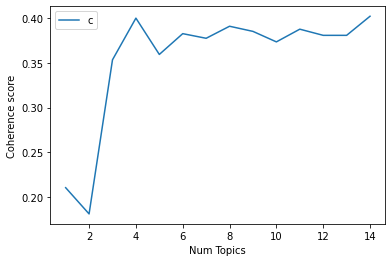

In [ ]:
limit=15; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



> Find Alpha



In [ ]:
def compute_parameter_values(dictionary, corpus, texts, limit, start, step):
    c=0
    coherence_values = []
    model_list = []
    for a in np.arange(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=bow_corpus, 
                                           id2word=dictionary,
                                           num_topics=6,
                                           random_state=100,
                                           chunksize=100,
                                           alpha=a,
                                           passes=10)
        
        model_list.append(model)
        c=c+1
        print(c)
        coherencemodel = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
model_list, coherence_values = compute_parameter_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, limit=0.99,start=0.1, step=0.1)

1
2
3
4
5
6
7
8
9


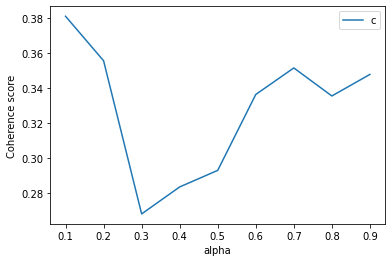

In [ ]:
limit=0.99; start=0.1; step=0.1;
x = np.arange(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("alpha")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



> Find eta



In [ ]:
def compute_parameter_values(dictionary, corpus, texts, limit, start, step):
    c=0
    coherence_values = []
    model_list = []
    for b in np.arange(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=bow_corpus, 
                                           id2word=dictionary,
                                           num_topics=6,
                                           random_state=100,
                                           chunksize=100,
                                           alpha=0.1,
                                           eta = b,
                                           passes=10)
        
        model_list.append(model)
        c=c+1
        print(c)
        coherencemodel = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
model_list, coherence_values = compute_parameter_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, limit=0.99,start=0.1, step=0.1)

1
2
3
4
5
6
7
8
9


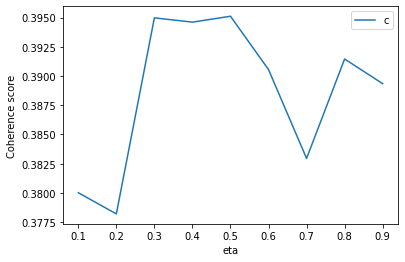

In [ ]:
 limit=0.99; start=0.1; step=0.1;
x = np.arange(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("eta")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=0.1,
                                       eta=0.3,
                                       per_word_topics=True)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.065*"เขื่อน" + 0.053*"อุปโภค" + 0.051*"บริโภค" + 0.049*"เทศบาลตำบล" + 0.047*"ทางหลวง" + 0.042*"เชียง" + 0.029*"เส้น" + 0.029*"องค์การบริหารส่วนตำบล" + 0.027*"ชนะ" + 0.026*"ท้องถิ่น"
Topic: 1 
Words: 0.094*"คอนกรีต" + 0.071*"ปรับปรุง" + 0.070*"ติก" + 0.057*"ผิว" + 0.054*"ผิวจราจร" + 0.049*"ถนนลาดยาง" + 0.036*"ถนน" + 0.031*"สร้าง" + 0.026*"เสริม" + 0.020*"พารา"
Topic: 2 
Words: 0.084*"พัฒนา" + 0.071*"ชุม" + 0.040*"เทศบาลตำบล" + 0.035*"ห้อง" + 0.034*"การเกษตร" + 0.028*"ปรับปรุง" + 0.028*"เส้นทาง" + 0.027*"ส่งเสริม" + 0.023*"เกษตร" + 0.022*"ลาน"
Topic: 3 
Words: 0.165*"ก่อสร้าง" + 0.157*"คอนกรีตเสริมเหล็ก" + 0.157*"ถนน" + 0.016*"โนน" + 0.014*"วัด" + 0.012*"ศรี" + 0.011*"คลอง" + 0.010*"ชัย" + 0.009*"ไหล่ทาง" + 0.009*"เชื่อม"
Topic: 4 
Words: 0.082*"บ่อ" + 0.077*"บาดาล" + 0.071*"ระบบ" + 0.057*"การเกษตร" + 0.055*"จุด" + 0.055*"ประปา" + 0.054*"ขุดเจาะ" + 0.033*"ท่อ" + 0.033*"ไทย" + 0.030*"น้ำ"
Topic: 5 
Words: 0.098*"กุด" + 0.071*"น้ำ" + 0.059*"ขุด" + 0.050*"คลอง" + 0.047*"ล

In [ ]:

# Let’s calculate the baseline coherence score
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39416273845170563


In [ ]:

for i,topic in enumerate(lda_model.print_topics(-1)):
    wp = lda_model.show_topic(i)
    topic_keywords = ", ".join([word for word, prop in wp])
    print(f'words for topic #{i}:')
    print(topic_keywords)
    print('\n')


words for topic #0:
เขื่อน, อุปโภค, บริโภค, เทศบาลตำบล, ทางหลวง, เชียง, เส้น, องค์การบริหารส่วนตำบล, ชนะ, ท้องถิ่น


words for topic #1:
คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดยาง, ถนน, สร้าง, เสริม, พารา


words for topic #2:
พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปรุง, เส้นทาง, ส่งเสริม, เกษตร, ลาน


words for topic #3:
ก่อสร้าง, คอนกรีตเสริมเหล็ก, ถนน, โนน, วัด, ศรี, คลอง, ชัย, ไหล่ทาง, เชื่อม


words for topic #4:
บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจาะ, ท่อ, ไทย, น้ำ


words for topic #5:
กุด, น้ำ, ขุด, คลอง, ลอก, วัง, มหา, บัว, อ้อม, ทราย




In [ ]:
def dominant_topic(ldamodel, corpus, texts):
     #Function to find the dominant topic in each review
    sent_topics_df = pd.DataFrame() 
     # Get main topic in each review
    for i, row in enumerate(ldamodel[corpus]):
         row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
         # Get the Dominant topic, Perc Contribution and Keywords for each review
         for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # =&gt; dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                 break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_dominant_topic = dominant_topic(ldamodel=lda_model, corpus=bow_corpus, texts=df_for_cluster['Project_name_Original']) 
df_dominant_topic.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Project_name_Original
0,2.0,0.4895,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า
1,2.0,0.8913,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...
2,2.0,0.8611,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",ศูนย์สั่งการความปลอดภัยเชิงบูรณการ
3,2.0,0.7347,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...
4,1.0,0.6420,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...
5,1.0,0.8652,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...
6,1.0,0.8588,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...
7,1.0,0.8341,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...
8,1.0,0.9042,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...
9,4.0,0.4230,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",ติดตั้งกล้องวงจรปิด บริเวณที่สาธารณะ ต.ศาลาด่าน


In [ ]:
df_dominant_topic.shape

(39522, 4)

In [ ]:
train_vecs = []
#token_l = []
#project_l = []
#project_re_l = []
for i in range(len(df_for_cluster)):
    top_topics = lda_model.get_document_topics(bow_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(6)]
    #print('topic_vec')
    #topic_vec.extend([df_for_cluster.iloc[i].real_counts]) # counts of reviews for restaurant
    #topic_vec.extend([len(df_for_cluster.iloc[i].Project_name)]) # length review
    train_vecs.append(topic_vec)
    #token_l.append(df_for_cluster.loc[i, 'TOKEN'])
   # project_l.append(df_for_cluster.loc[i, 'Project_name'])

In [ ]:
len(train_vecs)


39522

In [ ]:
len(df_for_cluster)

39522

In [ ]:
#df_lda = {'project_name': project_l,
#          'token': token_l,
#          'token_remove_stop_word': 
#          'vec': train_vecs}

#df_lda = pd.DataFrame(df_lda)
#df_lda.head()
df_for_cluster['vector'] = train_vecs
df_for_cluster.head()

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",0,"[0.017858712, 0.21553475, 0.4919055, 0.0178576..."
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",0,"[0.021739136, 0.021739133, 0.8913044, 0.021739..."
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,200000000.0,กระบี่,Krabi,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]","ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ",0,"[0.027777785, 0.027777784, 0.8611111, 0.027777..."
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,15000000.0,กระบี่,Krabi,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา...","เพิ่มประสิทธิภาพ,ดูแลรักษา,ความสะอาด,ชายหาด,รอ...",0,"[0.017857248, 0.19420144, 0.73436606, 0.017857..."
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...",0,"[0.005682028, 0.64540565, 0.005682076, 0.14682..."


In [ ]:
X = np.array(train_vecs)
X

array([[0.01785871, 0.21553475, 0.4919055 , 0.01785762, 0.01785856,
        0.23898482],
       [0.02173914, 0.02173913, 0.8913044 , 0.02173913, 0.02173913,
        0.02173913],
       [0.02777779, 0.02777778, 0.8611111 , 0.02777778, 0.02777779,
        0.02777779],
       ...,
       [0.01162791, 0.825584  , 0.01162811, 0.12790397, 0.01162812,
        0.01162791],
       [0.01315793, 0.93420047, 0.01315824, 0.01316051, 0.01315831,
        0.01316451],
       [0.127374  , 0.16529137, 0.00684975, 0.57943684, 0.00684976,
        0.11419828]], dtype=float32)

In [ ]:
#v = [' '.join(str(i)) for i in df_lda['vec']]
#df_lda['vec_seq'] = v
#df_lda.head(5)

,project_name,token,vec,vec_seq
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","[0.017859243, 0.21454148, 0.50179946, 0.017857...","[ 0 . 0 1 7 8 5 9 2 4 3 , 0 . 2 1 4 5 4 1 4 ..."
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่...","[0.02173916, 0.021739146, 0.89130425, 0.021739...","[ 0 . 0 2 1 7 3 9 1 6 , 0 . 0 2 1 7 3 9 1 4 ..."
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]","[0.027777823, 0.027777798, 0.861111, 0.0277777...","[ 0 . 0 2 7 7 7 7 8 2 3 , 0 . 0 2 7 7 7 7 7 ..."
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา...","[0.01785745, 0.017862473, 0.910707, 0.01785717...","[ 0 . 0 1 7 8 5 7 4 5 , 0 . 0 1 7 8 6 2 4 7 ..."
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","[0.0056828326, 0.64292395, 0.00568244, 0.14993...","[ 0 . 0 0 5 6 8 2 8 3 2 6 , 0 . 6 4 2 9 2 3 ..."


#KMeans after LDA



12198.876
9157.497078686056
6760.4310777621495
4896.000730532925
3296.0707052643443
2890.453495614946
2645.2783427997233
2449.2873949142954
2271.854243954875
2093.707380386929
1958.245606325149
1839.8126371522237
1733.0701619240997
1641.9779690888201


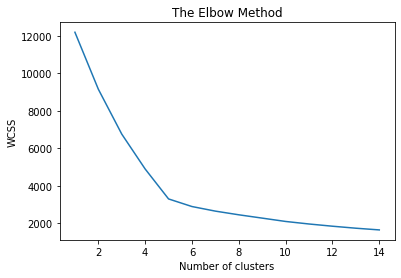

In [ ]:
from sklearn.cluster import KMeans
wcss1 = []

for i in range(1,15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    print(kmeans.inertia_)
    wcss1.append(kmeans.inertia_)
plt.plot(range(1,15),wcss1)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
#plt.savefig('elbow.png')
plt.show()

In [ ]:
k = 5
model = KMeans(n_clusters=k, init='k-means++',max_iter=300,n_init=10,random_state=42)
model.fit(X)
model.fit(X)
labels=model.labels_
df_for_cluster['cluster_of_LDA'] = labels
#df_cluster =pd.DataFrame(list(zip(df_token['TOKEN'],labels)),columns=['title','cluster'])
#print(df_token.sort_values(by=['cluster']))
df_for_cluster.head(5)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",0,"[0.017858712, 0.21553475, 0.4919055, 0.0178576...",3
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",0,"[0.021739136, 0.021739133, 0.8913044, 0.021739...",3
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,200000000.0,กระบี่,Krabi,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]","ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ",0,"[0.027777785, 0.027777784, 0.8611111, 0.027777...",3
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,15000000.0,กระบี่,Krabi,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา...","เพิ่มประสิทธิภาพ,ดูแลรักษา,ความสะอาด,ชายหาด,รอ...",0,"[0.017857248, 0.19420144, 0.73436606, 0.017857...",3
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...",0,"[0.005682028, 0.64540565, 0.005682076, 0.14682...",0


In [ ]:
g = df_for_cluster.groupby(['cluster_of_LDA'])['cluster_of_LDA'].count().sort_values()
g

cluster_of_LDA
2     5965
0     6074
3     6918
4     7854
1    12711
Name: cluster_of_LDA, dtype: int64

In [ ]:
df_for_cluster_0 = df_for_cluster[df_for_cluster['cluster_of_LDA'] == 0]
df_for_cluster_1 = df_for_cluster[df_for_cluster['cluster_of_LDA'] == 1]
df_for_cluster_2 = df_for_cluster[df_for_cluster['cluster_of_LDA'] == 2]
df_for_cluster_3 = df_for_cluster[df_for_cluster['cluster_of_LDA'] == 3]
df_for_cluster_4 = df_for_cluster[df_for_cluster['cluster_of_LDA'] == 4]

In [ ]:
print(len(df_for_cluster_0))
df_for_cluster_0['project_name_remove_stopword'].head(10)

6074


4     ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...
5     ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...
6     ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...
7     ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...
8     ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...
27    ซ่อม,สร้าง,ผิว,ติก,คอนกรีต,ถนน,พรุ,เตียว,ถนน,พ...
53    ปรับปรุง,ซ่อมแซม,ถนน,แอสฟัลต์,คอนกรีต,ทางหลวง,...
54    ซ่อม,สร้าง,ผิว,ติก,คอนกรีต,เมน,นิคม,คลอง,ท่อม,...
55    พัฒนา,โครงสร้างพื้นฐาน,ความเข้มแข็ง,เทศบาลตำบล...
56    ปรับปรุง,ผิวจราจร,คอนกรีตเสริมเหล็ก,ผิวจราจร,พ...
Name: project_name_remove_stopword, dtype: object

In [ ]:
print(len(df_for_cluster_1))
df_for_cluster_1['project_name_remove_stopword'].head(10)

12711


13                ก่อสร้าง,ถนน,แหล่งท่องเที่ยว,เกาะ,ศรี
24    ก่อสร้าง,บ่อ,สปา,สถานที่ท่องเที่ยว,น้ำตก,ร้อน,...
30           ปรับปรุง,ภูมิทัศน์,ถนน,คลอง,ม่วง,พระตำหนัก
49    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,บ้านใหญ่,วัด,โพ...
58                         ปรับปรุง,ถนน,จันทร์,กวี,ปลาย
60    ก่อสร้าง,ถนน,ติก,คอนกรีต,เหลียว,โตน,คีรี,ปลาย,...
62    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,ฉาย,คลอง,มัง,หน...
64               ก่อสร้าง,ถนนลาดยาง,ถ้ำ,เสือ,คลอง,เนียง
66    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,คีรี,ปลาย,พระยา...
68    ก่อสร้าง,ถนน,คอนกรีตเสริมเหล็ก,ทอง,ชัย,บุรี,หน...
Name: project_name_remove_stopword, dtype: object

In [ ]:
print(len(df_for_cluster_2))
df_for_cluster_2['project_name_remove_stopword'].head(10)

5965


16     ปรับปรุง,เขื่อน,ป้อง,กันน้ำ,เซาะ,บริเวณ,สถานที...
17     ขุด,ลอก,บำรุงรักษา,ร่องน้ำ,ชาย,ฝั่งทะเล,ท่า,เท...
35           จัดวาง,ทุ่น,ผูก,เรือ,กั้น,แนว,เล่น,น้ำ,อ่าว
81     ขุด,ลอก,ก่อสร้าง,ราง,ระบาย,น้ำ,คอนกรีตเสริมเหล...
102    ปรับปรุง,ถนน,คลอง,ทราย,ท่า,เลน,ก่อสร้าง,ระบาย,...
113                   พัฒนา,แหล่งท่องเที่ยว,คลอง,สอง,น้ำ
116              ขุด,ลอก,หนองน้ำ,สาธารณะ,เฉลิม,ธีร,พันธ์
117    ก่อสร้าง,ระบาย,น้ำ,คอนกรีตเสริมเหล็ก,โรงเรียนอ...
118                        ขุด,ลอก,ฝาย,คลอง,แรด,หิน,เพิง
124    ขุด,ลอก,ดิน,วัชพืช,สระน้ำ,สวน,สมเด็จ,พระ,ศรีนค...
Name: project_name_remove_stopword, dtype: object

In [ ]:
print(len(df_for_cluster_3))
df_for_cluster_3['project_name_remove_stopword'].head(10)

6918


0          ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า
1         พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน
2                   ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ
3     เพิ่มประสิทธิภาพ,ดูแลรักษา,ความสะอาด,ชายหาด,รอ...
10    พัฒนา,แหล่งท่องเที่ยว,อารยธรรม,โบราณ,โบราณ,ลูก...
11            พัฒนา,เส้นทาง,การท่องเที่ยว,อ่าว,แหลม,สัก
12    พัฒนา,เส้นทาง,ขนส่ง,ผลผลิต,การเกษตร,เชื่อมโยง,...
14    พัฒนา,เส้นทาง,ขนส่ง,ผลผลิต,การเกษตร,เชื่อมโยง,...
15    พัฒนา,เส้นทาง,ขนส่ง,ผลผลิต,การเกษตร,เชื่อมโยง,...
18    พัฒนา,เส้นทาง,ขนส่ง,ผลผลิต,การเกษตร,เชื่อมโยง,...
Name: project_name_remove_stopword, dtype: object

In [ ]:
print(len(df_for_cluster_4))
df_for_cluster_4['project_name_remove_stopword'].head(10)

7854


9      ติดตั้ง,กล้องวงจรปิด,บริเวณ,ที่สาธารณะ,ศาลา,ด่าน
22         ติดตั้ง,ไฟฟ้า,ส่องสว่าง,แหล่งท่องเที่ยว,อ่าว
23    ติดตั้ง,ซ่อมแซม,ขยาย,ไฟฟ้า,แสงสว่าง,สาธารณะ,ศา...
36    ปรับปรุง,ภูมิทัศน์,ก่อสร้าง,ประติมากรรม,หอย,ชั...
40       ถนน,กระบี่,ปลอดภัย,พลังงาน,ทางเลือก,แสงอาทิตย์
45    จัดซื้อ,ระบบ,ปรับปรุง,คุณภาพ,น้ำ,สมาร์ท,เพียว,...
46    จัดซื้อ,ระบบ,ปรับปรุง,คุณภาพ,น้ำ,สมาร์ท,เพียว,...
50    บริหาร,น้ำ,ปรัชญา,เศรษฐกิจพอเพียง,ธนาคาร,น้ำใต...
52             ก่อสร้าง,ถัง,ประปา,แชมเปญ,เจาะ,บ่อ,บาดาล
67    ก่อสร้าง,ฝายน้ำล้น,คอนกรีตเสริมเหล็ก,ฝัง,ท่อ,เ...
Name: project_name_remove_stopword, dtype: object

In [ ]:
texts = []
for i in df_for_cluster_0['TOKEN']:
  for j in i:
    texts.append(j)
#texts
text1 = ''
for i in texts:
  text1 += ' ' + i
#text1

In [ ]:
texts = []
for i in df_for_cluster_1['TOKEN']:
  for j in i:
    texts.append(j)
#texts
text2 = ''
for i in texts:
  text2 += ' ' + i
#text1

In [ ]:
texts = []
for i in df_for_cluster_2['TOKEN']:
  for j in i:
    texts.append(j)
#texts
text3 = ''
for i in texts:
  text3 += ' ' + i
#text1

In [ ]:
texts = []
for i in df_for_cluster_3['TOKEN']:
  for j in i:
    texts.append(j)
#texts
text4 = ''
for i in texts:
  text4 += ' ' + i
#text1

In [ ]:
texts = []
for i in df_for_cluster_4['TOKEN']:
  for j in i:
    texts.append(j)
#texts
text5 = ''
for i in texts:
  text5 += ' ' + i
#text1

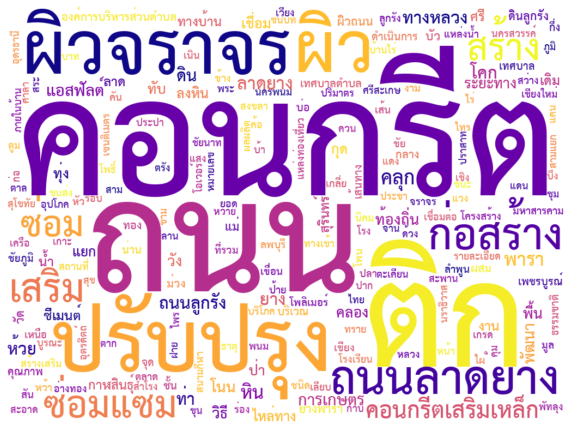

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

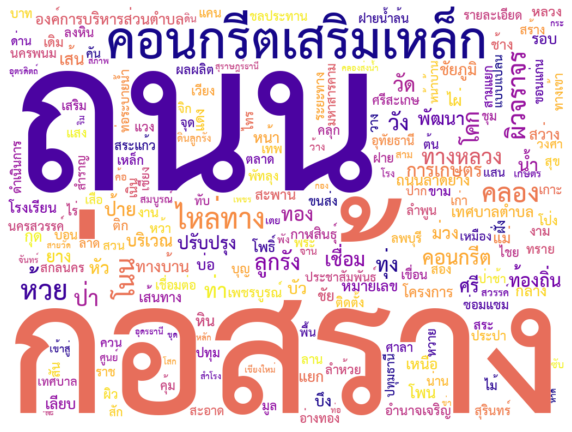

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text2)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

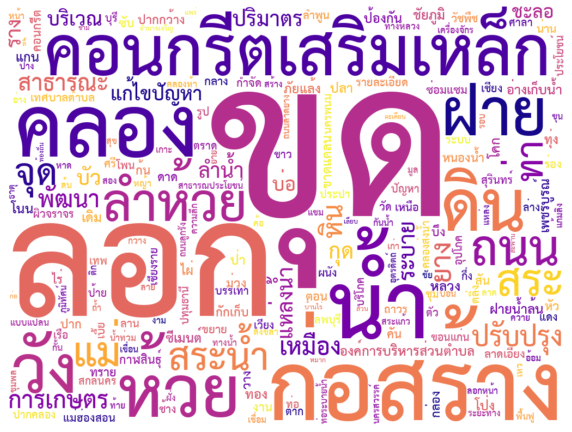

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text3)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

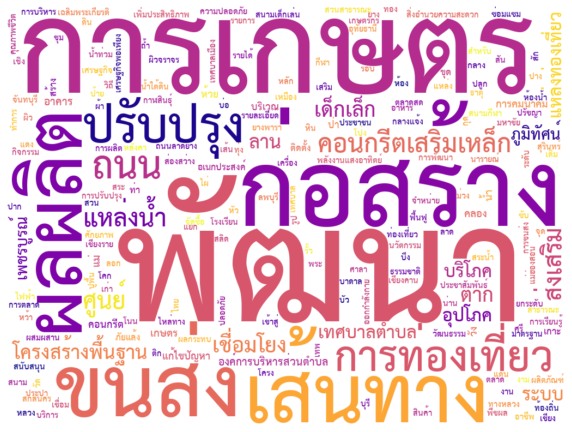

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text4)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

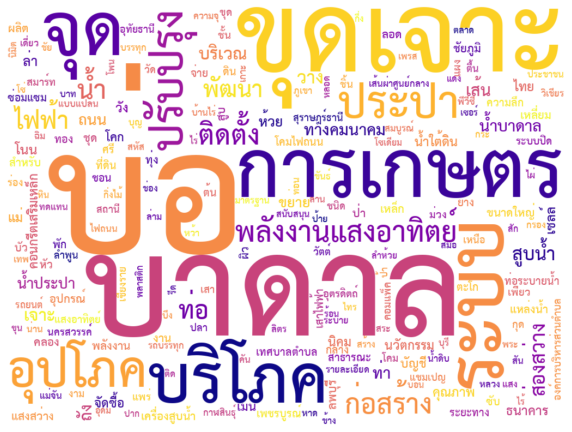

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      ).generate(text5)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

In [ ]:
df_for_cluster.to_csv('/content/drive/My Drive/Colab Notebooks/IS/insight/new_df_for_cluster.csv', index=False)

In [ ]:
df_for_cluster = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IS/insight/new_df_for_cluster.csv')
df_for_cluster.head(2)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",0,"[0.017858712, 0.21553475, 0.4919055, 0.0178576...",3
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"['พัฒนา', 'ศักยภาพ', 'เสริมสร้าง', 'ความเข้มแข...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",0,"[0.021739136, 0.021739133, 0.8913044, 0.021739...",3


In [ ]:
topic_1 = df_for_cluster[df_for_cluster['cluster_of_LDA'] == 0]
topic_1.head()

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ถนน', 'ติก', 'คอนกรีต', 'ชั้น', ...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...",0,"[0.005682028, 0.64540565, 0.005682076, 0.14682...",0
5,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9976000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยา...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...",0,"[0.0044249548, 0.871383, 0.004424895, 0.110915...",0
6,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9973000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยา...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...",0,"[0.0053766435, 0.8594636, 0.005376444, 0.06009...",0
7,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9806000.0,กระบี่,Krabi,"['ซ่อม', 'สร้าง', 'ถนน', 'ผิวจราจร', 'คอนกรีต'...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...",0,"[0.004629926, 0.83760375, 0.0046300357, 0.0046...",0
8,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3816000.0,กระบี่,Krabi,"['ซ่อม', 'สร้าง', 'ถนน', 'ผิวจราจร', 'คอนกรีต'...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...",0,"[0.0048547015, 0.90599686, 0.004854817, 0.0048...",0


In [ ]:
df_topic_1 = topic_1.copy()
df_topic_1.reset_index(inplace=True)
df_topic_1.drop(['index'], axis=1, inplace=True)
df_topic_1.head()

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA
0,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ถนน', 'ติก', 'คอนกรีต', 'ชั้น', ...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...",0,"[0.005682028, 0.64540565, 0.005682076, 0.14682...",0
1,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9976000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยา...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...",0,"[0.0044249548, 0.871383, 0.004424895, 0.110915...",0
2,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9973000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยา...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...",0,"[0.0053766435, 0.8594636, 0.005376444, 0.06009...",0
3,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9806000.0,กระบี่,Krabi,"['ซ่อม', 'สร้าง', 'ถนน', 'ผิวจราจร', 'คอนกรีต'...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...",0,"[0.004629926, 0.83760375, 0.0046300357, 0.0046...",0
4,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3816000.0,กระบี่,Krabi,"['ซ่อม', 'สร้าง', 'ถนน', 'ผิวจราจร', 'คอนกรีต'...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...",0,"[0.0048547015, 0.90599686, 0.004854817, 0.0048...",0


## Topic

In [ ]:
df_dominant_topic.to_csv('/content/drive/My Drive/Colab Notebooks/IS/insight/df_dominant_topic.csv', index=False)

In [ ]:
df_dominant_topic = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IS/insight/df_dominant_topic.csv')
df_dominant_topic.head(2)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Project_name_Original
0,2.0,0.4895,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า
1,2.0,0.8913,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...


In [ ]:
topic = []
for i in df_dominant_topic['Dominant_Topic']:
  topic.append(int(i))
 # print(int(i))

In [ ]:
df_for_cluster['Topic_Keywords'] = df_dominant_topic['Topic_Keywords']
df_for_cluster['Topic'] = topic

In [ ]:
df_for_cluster.head()

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,Topic_Keywords,Topic
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"[ส่งเสริม, สร้าง, รายได้, การจ้างแรงงาน, ตัด, ...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า","พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"[พัฒนา, ศักยภาพ, เสริมสร้าง, ความเข้มแข็ง, ยั่...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน","พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,200000000.0,กระบี่,Krabi,"[ศูนย์, สั่งการ, ความปลอดภัย, เชิง, บูรณ]","ศูนย์,สั่งการ,ความปลอดภัย,เชิง,บูรณ","พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,15000000.0,กระบี่,Krabi,"[เพิ่มประสิทธิภาพ, ดูแลรักษา, ความสะอาด, ชายหา...","เพิ่มประสิทธิภาพ,ดูแลรักษา,ความสะอาด,ชายหาด,รอ...","พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1


In [ ]:
TopicGr = df_for_cluster.groupby(['Topic']).size().sort_values(ascending = False)
TopicGr = TopicGr.reset_index()
TopicGr = TopicGr.rename({0: 'count'}, axis=1)
TopicGr

,Topic,count
0,3,13504
1,4,7674
2,2,6487
3,5,5536
4,1,5274
5,0,1047


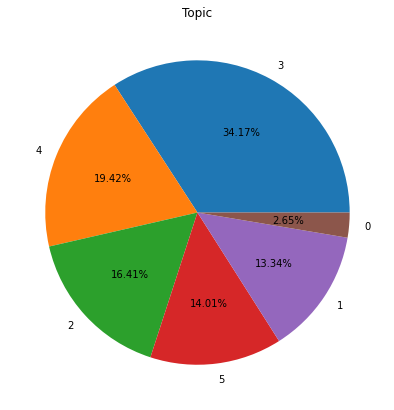

In [ ]:
fig = plt.figure(figsize =(10, 7)) 
plt.pie(TopicGr['count'], labels = TopicGr['Topic'], autopct='%.2f%%') 
  
# show plot
plt.title('Topic') 
plt.show() 


In [ ]:
topic_0 = df_for_cluster[df_for_cluster['Topic'] == 0]
t0 = {'Project_name_Original': topic_0['Project_name_Original'],
      'Topic_Keywords': topic_0['Topic_Keywords'],
      'Topic': topic_0['Topic']}
t0 = pd.DataFrame(t0)
t0.head(10)

,Project_name_Original,Topic_Keywords,Topic
106,ปรับปรุงระบบประปาบ้านท่าทองหลาง หมู่ที่ 6 บ้าน...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
121,ก่อสร้างท่าเทียบขนานยนต์ ท่าสุสาน–บ่อทุ่ง,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
123,โครงการท้องถิ่นไทย รวมใจภักดิ์ รักษ์พื้นที่สีเ...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
133,ปลูกต้นทองอุไร ริมถนนทางหลวงชนบท พง 3002,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
199,ปรับปรุงผิวจราจรถนนทางหลวงท้องถิ่น (พง.ถ.10018...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
266,โครงการซ่อมแซมถนน คอนกรีตเสริมเหล็ก คสล. สายว...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
511,โครงการปรับปรุงถนนลาดยางสายศิลา-ทำนบ หมู่ที่ ...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
535,โครงการก่อสร้างคูระบายน้ำถนนเทศบาล 10 เทศบาลตำ...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
560,โครงการก่อสร้างถนนลาดยางเขตกูวิง-สวนปาล์ม-ตงลอ...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0
563,โครงการก่อสร้างห้องน้ำบริเวณชายหาดอ่าวมะนาว อ...,"เขื่อน, เทศบาลตำบล, กุด, อุปโภค, บริโภค, ทางหล...",0


In [ ]:
topic_1 = df_for_cluster[df_for_cluster['Topic'] == 1]
t1 = {'Project_name_Original': topic_1['Project_name_Original'],
      'Topic_Keywords': topic_1['Topic_Keywords'],
      'Topic': topic_1['Topic']}
t1 = pd.DataFrame(t1)
t1.head(10)

,Project_name_Original,Topic_Keywords,Topic
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
5,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
6,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
7,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
8,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
27,ซ่อมสร้างผิวทางแอสฟัลท์ติกคอนกรีต ถนนสายพรุเตี...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
53,ปรับปรุงซ่อมแซมถนนแอสฟัลต์คอนกรีต รหัสทางหลวงท...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
54,ซ่อมสร้างผิวทางแอสฟัลท์ติกคอนกรีต สายเมนนิคม ห...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
56,ปรับปรุงผิวจราจร คอนกรีตเสริมเหล็ก คสล. เป็นผ...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
57,ก่อสร้างถนนลาดยางแบบพาราแอสฟัลท์คอนกรีตสายรอบอ...,"คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1


In [ ]:
topic_2 = df_for_cluster[df_for_cluster['Topic'] == 2]
t2 = {'Project_name_Original': topic_2['Project_name_Original'],
      'Topic_Keywords': topic_2['Topic_Keywords'],
      'Topic': topic_2['Topic']}
t2 = pd.DataFrame(t2)
t2.head(10)

,Project_name_Original,Topic_Keywords,Topic
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
2,ศูนย์สั่งการความปลอดภัยเชิงบูรณการ,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
3,เพิ่มประสิทธิภาพการดูแลรักษาความสะอาดชายหาดรอง...,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
10,พัฒนาแหล่งท่องเที่ยวอารยธรรมโบราณชุมชนโบราณลูก...,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
11,พัฒนาเส้นทางการท่องเที่ยวอ่าวลึก – แหลมสัก,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
12,พัฒนาเส้นทางขนส่งผลผลิตทางการเกษตรและเชื่อมโยง...,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
14,พัฒนาเส้นทางขนส่งผลผลิตทางการเกษตรและเชื่อมโยง...,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
15,พัฒนาเส้นทางขนส่งผลผลิตทางการเกษตรและเชื่อมโยง...,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2
18,พัฒนาเส้นทางขนส่งผลผลิตทางการเกษตรและเชื่อมโยง...,"พัฒนา, ชุม, เทศบาลตำบล, ห้อง, การเกษตร, ปรับปร...",2


In [ ]:
topic_3 = df_for_cluster[df_for_cluster['Topic'] == 3]
t3 = {'Project_name_Original': topic_3['Project_name_Original'],
      'Topic_Keywords': topic_3['Topic_Keywords'],
      'Topic': topic_3['Topic']}
t3 = pd.DataFrame(t3)
t3.head(10)

,Project_name_Original,Topic_Keywords,Topic
13,ก่อสร้างถนนแหล่งท่องเที่ยวเกาะศรีบอยา,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
24,ก่อสร้างบ่อสปา สถานที่ท่องเที่ยวน้ำตกร้อน/หมู่...,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
30,ปรับปรุงภูมิทัศน์ถนนสายคลองม่วง–พระตำหนัก หมู่ 2,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
49,ก่อสร้างถนนคอนกรีตเสริมเหล็กสายบ้านใหญ่ หมู่ที...,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
55,พัฒนาโครงสร้างพื้นฐานเพื่อความเข้มแข็งของชุมชน...,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
58,ปรับปรุงถนนจันทร์กวีกูลช่วงปลาย,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
60,ก่อสร้างถนนแอสฟัลส์ติกคอนกรีตสายบางเหลียว-หูโต...,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
62,ก่อสร้างถนนคอนกรีตเสริมเหล็กสาย บ.นายฉาย–คลองท...,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
64,ก่อสร้างถนนลาดยางสายถ้ำเสือ 2 – คลองเนียง,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3
66,ก่อสร้างถนน คอนกรีตเสริมเหล็ก คสล. สายซอย 2 หม...,"ก่อสร้าง, ถนน, คอนกรีตเสริมเหล็ก, โนน, วัด, ศร...",3


In [ ]:
topic_4 = df_for_cluster[df_for_cluster['Topic'] == 4]
t4 = {'Project_name_Original': topic_4['Project_name_Original'],
      'Topic_Keywords': topic_4['Topic_Keywords'],
      'Topic': topic_4['Topic']}
t4 = pd.DataFrame(t4)
t4.head(10)

,Project_name_Original,Topic_Keywords,Topic
9,ติดตั้งกล้องวงจรปิด บริเวณที่สาธารณะ ต.ศาลาด่าน,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
22,ติดตั้งไฟฟ้าส่องสว่างแหล่งท่องเที่ยวอ่าวนาง,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
23,ติดตั้งซ่อมแซมและขยายเขตไฟฟ้าแสงสว่างสาธารณะใน...,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
34,ก่อสร้างระบบรวบรวมน้ำเสียและระบบบำบัดน้ำเสีย ค...,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
36,ปรับปรุงภูมิทัศน์และก่อสร้างประติมากรรมหอยชักตีน,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
40,ถนน อบจ.กระบี่ ปลอดภัยด้วยพลังงานทางเลือกจากแส...,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
45,จัดซื้อระบบปรับปรุงคุณภาพน้ำ สมาร์ทเพียวคอมแพ็ค,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
46,จัดซื้อระบบปรับปรุงคุณภาพน้ำ สมาร์ทเพียวคอมแพ็ค,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
50,บริหารจัดการน้ำตามปรัชญาของเศรษฐกิจพอเพียง (ธน...,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4
52,ก่อสร้างหอถังประปาแบบแชมเปญ พร้อมเจาะบ่อบาดาล ...,"บ่อ, บาดาล, ระบบ, การเกษตร, จุด, ประปา, ขุดเจา...",4


In [ ]:
topic_5 = df_for_cluster[df_for_cluster['Topic'] == 5]
t5 = {'Project_name_Original': topic_5['Project_name_Original'],
      'Topic_Keywords': topic_5['Topic_Keywords'],
      'Topic': topic_5['Topic']}
t5 = pd.DataFrame(t5)
t5.head(10)

,Project_name_Original,Topic_Keywords,Topic
16,ปรับปรุงเขื่อนป้องกันน้ำเซาะบริเวณสถานที่ท่องเ...,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
17,ขุดลอกและบำรุงรักษาร่องน้ำชายฝั่งทะเลท่าเทียบแ...,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
35,จัดวางทุ่นผูกเรือและกั้นแนวเล่นน้ำในเขตพื้นที่...,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
81,ขุดลอกพร้อมก่อสร้างรางระบายน้ำ คอนกรีตเสริมเหล...,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
113,พัฒนาแหล่งท่องเที่ยวคลองสองน้ำ,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
116,ขุดลอกหนองน้ำสาธารณะบ้านนายเฉลิม อัขรธีรพันธ์,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
117,ก่อสร้างคูระบายน้ำคอนกรีตเสริมเหล็ก โรงเรียนอน...,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
118,ขุดลอกฝายคลองแรด หมู่ที่ 8 บ้านหินเพิง,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
124,โครงการขุดลอกดินและวัชพืชสระน้ำภายในสวนสมเด็จพ...,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5
136,โครงการปรับภูมิทัศน์ริมถนนสองข้างทางสายท่าหัน-...,"น้ำ, ขุด, คลอง, ลอก, วัง, กุด, มหา, บัว, อ้อม,...",5


# 6. Project Anomaly Detection

##6.1 Label Encoder

In [ ]:
df_for_cluster.head(2)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,Krabi,"['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",0,"[0.017858712, 0.21553475, 0.4919055, 0.0178576...",3
1,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,พัฒนาศักยภาพและเสริมสร้างความเข้มแข็งของชุมชนอ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,448500.0,กระบี่,Krabi,"['พัฒนา', 'ศักยภาพ', 'เสริมสร้าง', 'ความเข้มแข...","พัฒนา,ศักยภาพ,เสริมสร้าง,ความเข้มแข็ง,ยั่งยืน",0,"[0.021739136, 0.021739133, 0.8913044, 0.021739...",3


In [ ]:
topic_1.head()

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,Topic_Keywords,Topic
4,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
5,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9976000.0,กระบี่,Krabi,"[ก่อสร้าง, ซ่อมแซม, สร้าง, ผิว, ลาดยาง, พารา, ...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
6,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9973000.0,กระบี่,Krabi,"[ก่อสร้าง, ซ่อมแซม, สร้าง, ผิว, ลาดยาง, พารา, ...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
7,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9806000.0,กระบี่,Krabi,"[ซ่อม, สร้าง, ถนน, ผิวจราจร, คอนกรีต, ชั้น, พื...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
8,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3816000.0,กระบี่,Krabi,"[ซ่อม, สร้าง, ถนน, ผิวจราจร, คอนกรีต, ชั้น, พื...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1


In [ ]:
df_topic_1 = topic_1.copy()
df_topic_1.reset_index(inplace=True)
df_topic_1.drop(['index'], axis=1, inplace=True)
df_topic_1.head()

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,Topic_Keywords,Topic
0,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"[ก่อสร้าง, ถนน, ติก, คอนกรีต, ชั้น, พื้น, ดิน,...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
1,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9976000.0,กระบี่,Krabi,"[ก่อสร้าง, ซ่อมแซม, สร้าง, ผิว, ลาดยาง, พารา, ...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
2,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9973000.0,กระบี่,Krabi,"[ก่อสร้าง, ซ่อมแซม, สร้าง, ผิว, ลาดยาง, พารา, ...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
3,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9806000.0,กระบี่,Krabi,"[ซ่อม, สร้าง, ถนน, ผิวจราจร, คอนกรีต, ชั้น, พื...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1
4,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3816000.0,กระบี่,Krabi,"[ซ่อม, สร้าง, ถนน, ผิวจราจร, คอนกรีต, ชั้น, พื...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...","คอนกรีต, ปรับปรุง, ติก, ผิว, ผิวจราจร, ถนนลาดย...",1


In [ ]:
labelencoder = LabelEncoder()

In [ ]:
df_topic_1['province_label'] = labelencoder.fit_transform(df_topic_1['province'])
#df_for_cluster['unit_label'] = labelencoder.fit_transform(df_for_cluster['unit'])
#df_for_cluster['ministry_label'] = labelencoder.fit_transform(df_for_cluster['ministry'])
#df_for_cluster['province_label'] = labelencoder.fit_transform(df_for_cluster['province'])
#df_for_cluster.head(2)
df_topic_1.head(2)

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA,province_label
0,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ถนน', 'ติก', 'คอนกรีต', 'ชั้น', ...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...",0,"[0.005682028, 0.64540565, 0.005682076, 0.14682...",0,0
1,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9976000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยา...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...",0,"[0.0044249548, 0.871383, 0.004424895, 0.110915...",0,0


##6.2 Plot raw data



> plot boxplot (budget)



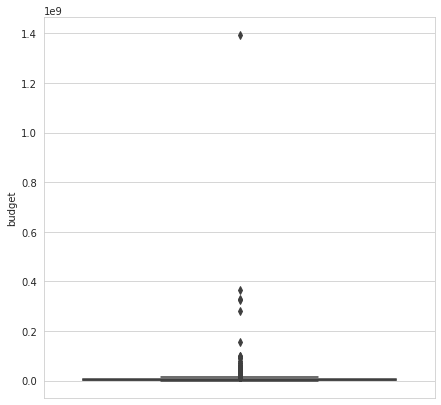

In [ ]:
plt.figure(figsize=(7,7))
sns.set_style('whitegrid')

data = df_topic_1['budget']

sns.boxplot(y=data)

In [ ]:
#filter outliers

outliers = [i for i in df_topic_1['budget'] if i > 1.2*(10**9)]
print('Outlier budget: ', outliers, 'this budget is more than :', 1.2*(10**9), ' million baht')
proj1 =''
prov1 = ''
proj2 = ''
prov2 = ''
proj3 = ''
prov3 = ''
for i in range(len(df_topic_1)):
  if df_topic_1.loc[i, 'budget'] == 1395026100.0:
    proj1 = df_topic_1.loc[i, 'Project_name_Original']
    prov1 = df_topic_1.loc[i, 'province']
  #elif df_topic_1.loc[i, 'budget'] == 325710000.0:
  #  proj2 = df_topic_1.loc[i, 'Project_name_Original']
  #  prov2 = df_topic_1.loc[i, 'province']
  #elif df_topic_1.loc[i, 'budget'] == 366332000.0:
  #  proj3 = df_topic_1.loc[i, 'Project_name_Original']
  #  prov3 = df_topic_1.loc[i, 'province']
print('Project:')
print('1. ',proj1, ' ',prov1)
#print('2. ',proj2, ' ',prov2 )
#print('3. ',proj3, ' ',prov3 )

Outlier budget:  [1395026100.0] this budget is more than : 1200000000.0  million baht
Project:
1.  โครงการด้านอื่นๆ   ขอนแก่น




> Plot between budget and topic



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x720 with 0 Axes>

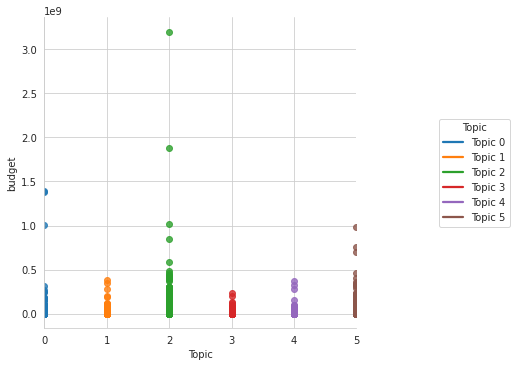

In [ ]:
plt.figure(figsize=(10,10))
g = sns.lmplot('Topic', 'budget', data=df_for_cluster, hue='Topic', legend=False)
plt.legend(title='Topic', loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, labels=['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])
#g.legend.set_title('cluster')
#plt.legend(title='Cluster', loc='upper left', labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x1440 with 0 Axes>

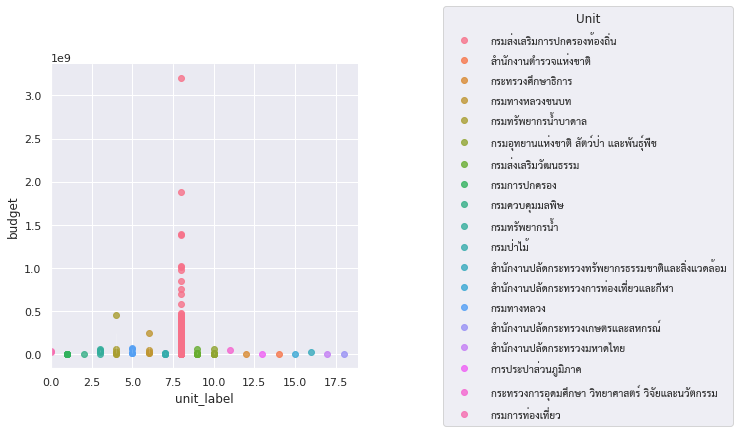

In [ ]:
from matplotlib.font_manager import FontProperties
f = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=15)

plt.figure(figsize=(10,20))
g = sns.lmplot('unit_label', 'budget', data=df_for_cluster, hue='unit', legend=False)
#plt.legend(title='Unit', loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.legend(title='Unit',loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, prop=f)
plt.show()



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x1440 with 0 Axes>

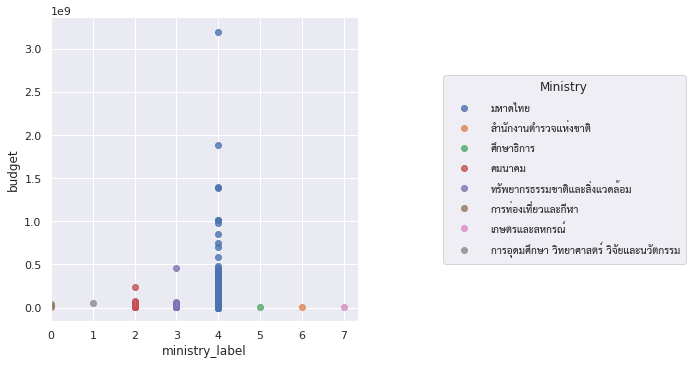

In [ ]:
from matplotlib.font_manager import FontProperties
f = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=15)

plt.figure(figsize=(10,20))
g = sns.lmplot('ministry_label', 'budget', data=df_for_cluster, hue='ministry', legend=False)
#plt.legend(title='Unit', loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.legend(title='Ministry',loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, prop=f)
plt.show()



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x1440 with 0 Axes>

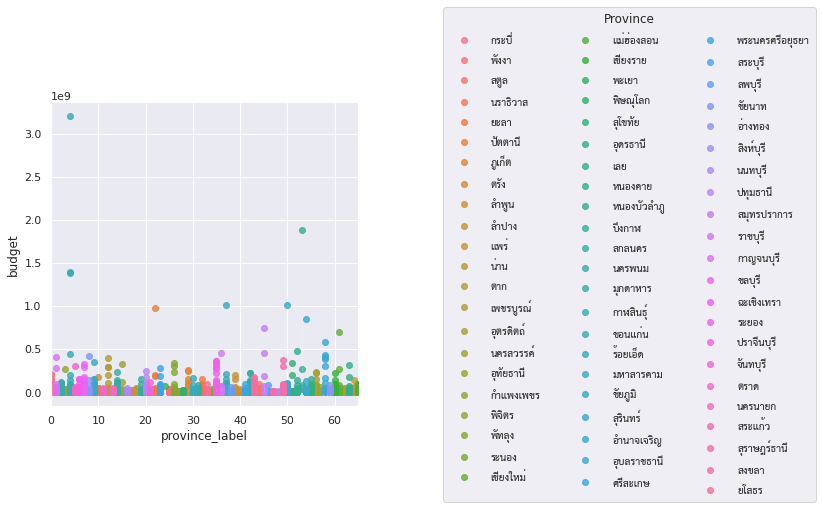

In [ ]:
from matplotlib.font_manager import FontProperties
f = FontProperties(fname='/content/drive/My Drive/Colab Notebooks/IS/insight/THSarabunNew Bold.ttf', size=15)

plt.figure(figsize=(10,20))
g = sns.lmplot('province_label', 'budget', data=df_for_cluster, hue='province', legend=False)
#plt.legend(title='Unit', loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.legend(title='Province',loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3, prop=f)
plt.show()

## 6.3 Standardization

In [ ]:
df_for_cluster.head(1)

,Project_name,unit,ministry,budget,province,TOKEN,project_name_remove_stopword,cluster,project_name_ori,eng_province,unit_label,ministry_label,province_label
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,866000.0,กระบี่,"['ส่งเสริม', 'สร้าง', 'รายได้', 'การจ้างแรงงาน...","ส่งเสริม,สร้าง,รายได้,การจ้างแรงงาน,ตัด,หญ้า",1,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,Krabi,8,4,0


In [ ]:
df_for_anomaly = {'project_name': df_for_cluster['project_name_ori'],
                  'budget': df_for_cluster['budget'],
                  'unit' : df_for_cluster['unit_label'],
                  'ministry': df_for_cluster['ministry_label'],
                  'province': df_for_cluster['province_label'],
                  'cluster': df_for_cluster['cluster']}

df_for_anomaly = pd.DataFrame(df_for_anomaly)
df_for_anomaly.head(1)

,project_name,budget,unit,ministry,province,cluster
0,ส่งเสริมการสร้างรายได้ด้วยการจ้างแรงงานตัดหญ้า,866000.0,8,4,0,1


In [ ]:
df_for_anomaly.iloc[:,1:]

,budget,unit,ministry,province,cluster
0,866000.0,8,4,0,1
1,448500.0,8,4,0,1
2,200000000.0,8,4,0,1
3,15000000.0,8,4,0,1
4,9750000.0,8,4,0,1
...,...,...,...,...,...
39515,1862000.0,8,4,23,1
39516,1685000.0,8,4,23,1
39517,2000000.0,8,4,23,0
39518,491000.0,8,4,23,1


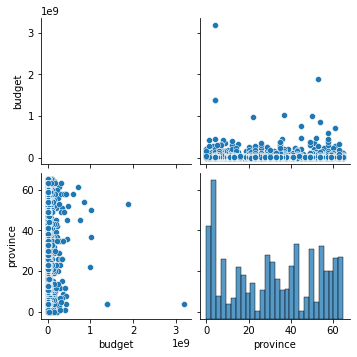

In [ ]:
sns.pairplot(df_for_anomaly)

In [ ]:
scaler = StandardScaler()
df_for_anomaly_std = scaler.fit_transform(df_for_anomaly.iloc[:,1:])
df_for_anomaly_std

array([[-0.11025009,  0.01081373,  0.02466537, -1.51718189,  0.51519506],
       [-0.12522394,  0.01081373,  0.02466537, -1.51718189,  0.51519506],
       [ 7.0317932 ,  0.01081373,  0.02466537, -1.51718189,  0.51519506],
       ...,
       [-0.06957859,  0.01081373,  0.02466537, -0.41238286, -1.29237851],
       [-0.12369966,  0.01081373,  0.02466537, -0.41238286,  0.51519506],
       [-0.01111781,  0.01081373,  0.02466537, -0.41238286, -1.29237851]])

## 6.4 Dimension Reduction

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(df_for_anomaly_std)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_

array([1.39396806, 1.056852  ])

In [ ]:
pca.explained_variance_ratio_

array([0.27878656, 0.21136505])

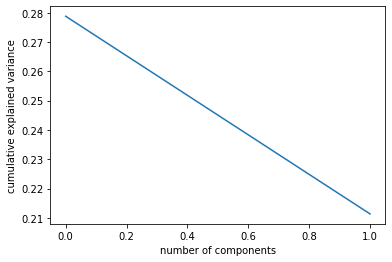

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Text(0, 0.5, 'Cumulative Expained Variance')

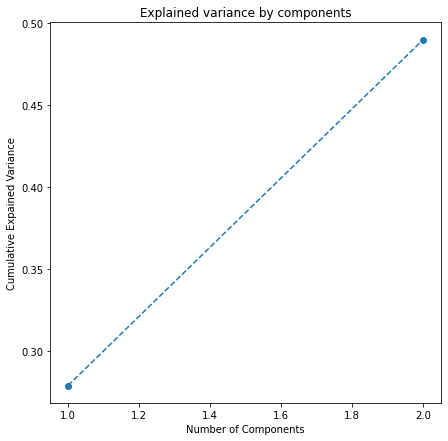

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(range(1,3), pca.explained_variance_ratio_.cumsum(), marker='o',linestyle='--')
plt.title('Explained variance by components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Expained Variance')

In [ ]:
#pca = PCA(n_components=4)

In [ ]:
#pca.fit(df_for_anomaly_std)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.transform(df_for_anomaly_std) 

array([[ 0.01895336,  1.29937031],
       [ 0.017479  ,  1.29443024],
       [ 0.72217912,  3.65562384],
       ...,
       [-0.07574247, -0.63688781],
       [-0.00683746,  0.57982427],
       [-0.06998625, -0.61760083]])

In [ ]:
score_pca = pca.transform(df_for_anomaly_std)
score_pca

array([[ 0.01895336,  1.29937031],
       [ 0.017479  ,  1.29443024],
       [ 0.72217912,  3.65562384],
       ...,
       [-0.07574247, -0.63688781],
       [-0.00683746,  0.57982427],
       [-0.06998625, -0.61760083]])


## 6.5 Isolation Forest

In [ ]:
X = df_topic_1[['budget',  'province_label']]

from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100,  contamination=0.001, max_samples='auto', random_state=0)
clf.fit(X)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.001,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

In [ ]:
df_topic_1['scores']=clf.decision_function(X)
df_topic_1['anomaly']=clf.predict(X)
df_topic_1.head()

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA,province_label,scores,anomaly
0,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,ก่อสร้างถนนแอสฟัลท์ติก คอนกรีต ชั้นพื้นทา...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9750000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ถนน', 'ติก', 'คอนกรีต', 'ชั้น', ...","ก่อสร้าง,ถนน,ติก,คอนกรีต,ชั้น,พื้น,ดิน,ซีเมนต์...",0,"[0.005682028, 0.64540565, 0.005682076, 0.14682...",0,0,0.218555,1
1,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9976000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยา...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...",0,"[0.0044249548, 0.871383, 0.004424895, 0.110915...",0,0,0.215182,1
2,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,ก่อสร้างซ่อมแซมสร้างผิวทางลาดยางแบบพาราแอสฟัลต...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9973000.0,กระบี่,Krabi,"['ก่อสร้าง', 'ซ่อมแซม', 'สร้าง', 'ผิว', 'ลาดยา...","ก่อสร้าง,ซ่อมแซม,สร้าง,ผิว,ลาดยาง,พารา,ติก,คอน...",0,"[0.0053766435, 0.8594636, 0.005376444, 0.06009...",0,0,0.215182,1
3,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9806000.0,กระบี่,Krabi,"['ซ่อม', 'สร้าง', 'ถนน', 'ผิวจราจร', 'คอนกรีต'...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...",0,"[0.004629926, 0.83760375, 0.0046300357, 0.0046...",0,0,0.215550,1
4,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,ซ่อมสร้างถนนผิวจราจรแอสฟัลท์คอนกรีตชั้นพื้นทาง...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3816000.0,กระบี่,Krabi,"['ซ่อม', 'สร้าง', 'ถนน', 'ผิวจราจร', 'คอนกรีต'...","ซ่อม,สร้าง,ถนน,ผิวจราจร,คอนกรีต,ชั้น,พื้น,ดิน,...",0,"[0.0048547015, 0.90599686, 0.004854817, 0.0048...",0,0,0.240311,1


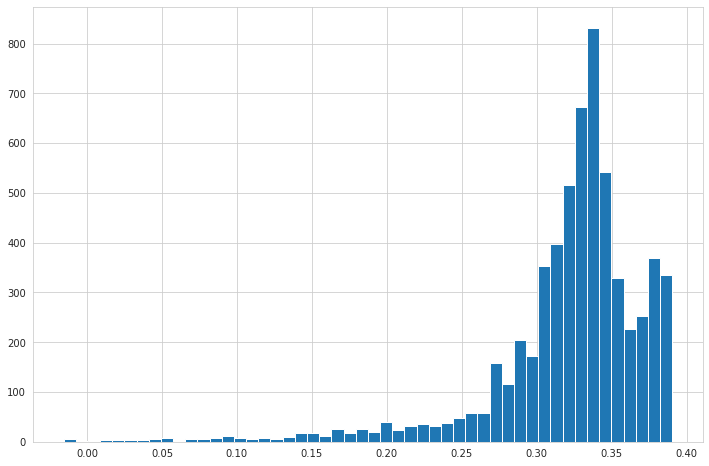

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(df_topic_1['scores'], bins=50);

In [ ]:
anomaly_gr = df_topic_1.groupby(['anomaly'])['anomaly'].size().sort_values(ascending=False)
anomaly_gr

anomaly
 1    6067
-1       7
Name: anomaly, dtype: int64

In [ ]:
anomaly=df_topic_1.loc[df_topic_1['anomaly']==-1]
anomaly

,Project_name,Project_name_Original,unit,ministry,budget,province,Eng_province,TOKEN,project_name_remove_stopword,cluster,vector,cluster_of_LDA,province_label,scores,anomaly
3148,ด้านอื่นๆ,โครงการด้านอื่นๆ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,1.395026e+09,ขอนแก่น,Khon Kaen,[],NaN,0,"[0.16666666, 0.16666666, 0.16666666, 0.1666666...",0,4,-0.012497,-1
3271,ก่อสร้างปรับปรุงผิวจราจรแอสฟัลส์ติก แบบโอเวอร...,ก่อสร้างปรับปรุงผิวจราจรแอสฟัลส์ติก (แบบโอเวอร...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,1.547410e+08,ร้อยเอ็ด,Roi Et,"['ก่อสร้าง', 'ปรับปรุง', 'ผิวจราจร', 'ติก', 'โ...","ก่อสร้าง,ปรับปรุง,ผิวจราจร,ติก,โอเวอร์,โครงการ",0,"[0.01515152, 0.6212961, 0.015152006, 0.3180968...",0,35,-0.000108,-1
4720,ปรับปรุงถนนพัฒนาการ อำเภอเมืองฯ จังหวัดกาญจนบุ...,ปรับปรุงถนนพัฒนาการ อำเภอเมืองฯ จังหวัดกาญจนบุ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,2.800000e+08,กาญจนบุรี,Kanchanaburi,"['ปรับปรุง', 'ถนน', 'พัฒนาการ', 'กาญจนบุรี', '...","ปรับปรุง,ถนน,พัฒนาการ,กาญจนบุรี,วาง,ท่อระบายน้...",0,"[0.006024265, 0.38498053, 0.08908805, 0.160016...",0,1,-0.015695,-1
4787,ปรับปรุงถนนพัทยาสาย และพื้นที่ใกล้เคียง ช่วงพ...,โครงการปรับปรุงถนนพัทยาสาย 2 และพื้นที่ใกล้เคี...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3.270000e+08,ชลบุรี,Chon Buri,"['ปรับปรุง', 'ถนน', 'พัทยา', 'ใกล้เคียง', 'พัท...","ปรับปรุง,ถนน,พัทยา,ใกล้เคียง,พัทยา,กลาง,พัทยา",0,"[0.61822116, 0.3211582, 0.015152607, 0.0151638...",0,7,-0.012404,-1
4858,ก่อสร้างปรับปรุงถนน รย ถ สายตอนแยกทางหลวงหมา...,ก่อสร้างปรับปรุงถนน รย.ถ.10036 สายตอนแยกทางหล...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3.257100e+08,ระยอง,Rayong,"['ก่อสร้าง', 'ปรับปรุง', 'ถนน', 'ตอน', 'แยก', ...","ก่อสร้าง,ปรับปรุง,ถนน,ตอน,แยก,ทางหลวง,หมายเลข,...",0,"[0.36040008, 0.429481, 0.008621268, 0.18425442...",0,33,-0.014770,-1
4859,ก่อสร้างปรับปรุงถนน รย ถ สายตอนแยกทางหลวงหมา...,ก่อสร้างปรับปรุงถนน รย.ถ.10036/สายตอนแยกทางหล...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,3.663320e+08,ระยอง,Rayong,"['ก่อสร้าง', 'ปรับปรุง', 'ถนน', 'ตอน', 'แยก', ...","ก่อสร้าง,ปรับปรุง,ถนน,ตอน,แยก,ทางหลวง,หมายเลข,...",0,"[0.3603961, 0.42950648, 0.008621268, 0.1842329...",0,33,-0.014770,-1
5166,จัดสร้างแพขนานยนต์ จำนวน ลำ,จัดสร้างแพขนานยนต์ จำนวน 2 ลำ,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,9.000000e+07,สงขลา,Songkhla,"['สร้าง', 'แพขนานยนต์']","สร้าง,แพขนานยนต์",0,"[0.0625, 0.6875, 0.0625, 0.0625, 0.0625, 0.0625]",0,41,-0.003188,-1


In [ ]:
province_anomaly = anomaly.groupby(['province'])['province'].size().sort_values(ascending=False)
province_anomaly

province
ระยอง        2
สงขลา        1
ร้อยเอ็ด     1
ชลบุรี       1
ขอนแก่น      1
กาญจนบุรี    1
Name: province, dtype: int64

In [ ]:
df_topic_1['digits'] = df_topic_1.budget.map(lambda x: len(str(round(x))) if x==x else x)
dg = df_topic_1.groupby(['digits', 'anomaly']).Project_name.count().sort_values(ascending = False).reset_index()
dg

,digits,anomaly,Project_name
0,7,1,3099
1,6,1,2449
2,8,1,487
3,5,1,32
4,9,-1,5
5,10,-1,1
6,8,-1,1


In [ ]:
anomaly_index=list(anomaly.index)
#anomaly_index

In [ ]:
r = {'budget': df_topic_1['budget'],
     'province' : df_topic_1['province_label'],
     'ENG_province' : df_topic_1['Eng_province'],
     'anomaly' : df_topic_1['anomaly']}
res = pd.DataFrame(r)
res.head(2)

,budget,province,ENG_province,anomaly
0,9750000.0,0,Krabi,1
1,9976000.0,0,Krabi,1


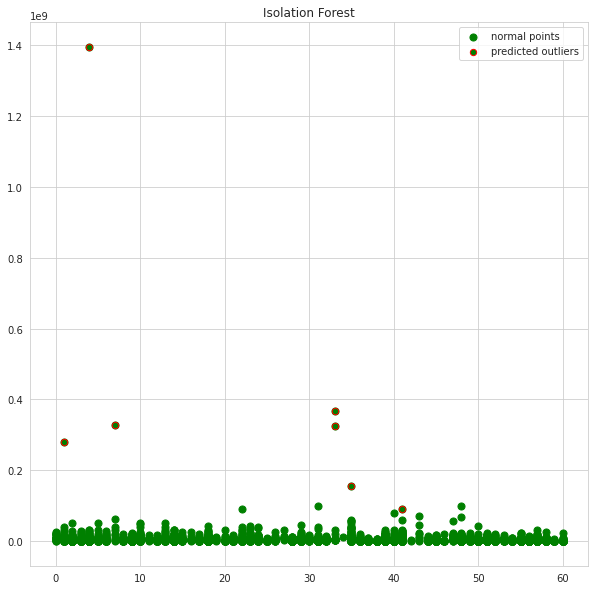

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Isolation Forest")
#plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(df_topic_1['province_label'], df_topic_1['budget'], c='green',
                 s=50,label="normal points")

b1 =plt.scatter(res.iloc[anomaly_index,1],res.iloc[anomaly_index,0], c='green',s=40,  edgecolor="red",label="predicted outliers")
plt.legend(loc="best")
plt.show()

In [ ]:
#filter outliers

outliers = [i for i in df_topic_1['budget'] if i > 0.2*(10**9)]
print('Outlier budget: ', outliers, 'this budget is more than :', 0.2*(10**9), ' million baht')
proj1 =''
prov1 = ''
proj2 = ''
prov2 = ''
proj3 = ''
prov3 = ''
proj4 = ''
prov4 = ''
proj5 = ''
prov5 = ''
proj6 = ''
prov6 = ''
for i in range(len(df_topic_1)):
  if df_topic_1.loc[i, 'budget'] == 1395026100.0:
    proj1 = df_topic_1.loc[i, 'Project_name_Original']
    prov1 = df_topic_1.loc[i, 'province']
  elif df_topic_1.loc[i, 'budget'] == 280000000.0:
    proj2 = df_topic_1.loc[i, 'Project_name_Original']
    prov2 = df_topic_1.loc[i, 'province']
  elif df_topic_1.loc[i, 'budget'] == 327000000.0:
    proj3 = df_topic_1.loc[i, 'Project_name_Original']
    prov3 = df_topic_1.loc[i, 'province']
  elif df_topic_1.loc[i, 'budget'] == 325710000.0:
    proj4 = df_topic_1.loc[i, 'Project_name_Original']
    prov4 = df_topic_1.loc[i, 'province']
  elif df_topic_1.loc[i, 'budget'] == 366332000.0:
    proj5 = df_topic_1.loc[i, 'Project_name_Original']
    prov5 = df_topic_1.loc[i, 'province']
  #elif df_topic_1.loc[i, 'budget'] == 90000000.0:
  #  proj6 = df_topic_1.loc[i, 'Project_name_Original']
  #  prov6 = df_topic_1.loc[i, 'province']
print('Project:')
print('1. ',proj1, ' ',prov1)
print('2. ',proj2, ' ',prov2 )
print('3. ',proj3, ' ',prov3 )
print('4. ',proj4, ' ',prov4 )
print('5. ',proj5, ' ',prov5 )
#print('6. ',proj6, ' ',prov6 )

Outlier budget:  [1395026100.0, 280000000.0, 327000000.0, 325710000.0, 366332000.0] this budget is more than : 200000000.0  million baht
Project:
1.  โครงการด้านอื่นๆ   ขอนแก่น
2.  ปรับปรุงถนนพัฒนาการ อำเภอเมืองฯ จังหวัดกาญจนบุรี โดยการวางท่อระบายน้ำ คอนกรีตเสริมเหล็ก คสล.  วางท่อระบายน้ำลอดทางรถไฟ และซ่อมสร้างปูผิวด้วยพาราแอสฟัลท์คอนกรีต   กาญจนบุรี
3.  โครงการปรับปรุงถนนพัทยาสาย 2 และพื้นที่ใกล้เคียง ช่วงพัทยากลาง – พัทยาใต้   ชลบุรี
4.  ก่อสร้างปรับปรุงถนน  รย.ถ.10036 สายตอนแยกทางหลวงหมายเลข 3 (เขาดิน) หนองเสม็ด อำเภอแกลง,           อำเภอเขาชะเมา จังหวัดระยอง (ระยะที่ 1)   ระยอง
5.  ก่อสร้างปรับปรุงถนน  รย.ถ.10036/สายตอนแยกทางหลวงหมายเลข 3/(เขาดิน) หนองเสม็ด อำเภอแกลง, /อำเภอเขาชะเมา จังหวัดระยอง (ระยะที่ 2)   ระยอง


In [ ]:
anomaly[['Project_name','province','province_label','budget']].sort_values(by=['province_label'])

,Project_name,province,province_label,budget
4720,ปรับปรุงถนนพัฒนาการ อำเภอเมืองฯ จังหวัดกาญจนบุ...,กาญจนบุรี,1,2.800000e+08
3148,ด้านอื่นๆ,ขอนแก่น,4,1.395026e+09
4787,ปรับปรุงถนนพัทยาสาย และพื้นที่ใกล้เคียง ช่วงพ...,ชลบุรี,7,3.270000e+08
4858,ก่อสร้างปรับปรุงถนน รย ถ สายตอนแยกทางหลวงหมา...,ระยอง,33,3.257100e+08
4859,ก่อสร้างปรับปรุงถนน รย ถ สายตอนแยกทางหลวงหมา...,ระยอง,33,3.663320e+08
3271,ก่อสร้างปรับปรุงผิวจราจรแอสฟัลส์ติก แบบโอเวอร...,ร้อยเอ็ด,35,1.547410e+08
5166,จัดสร้างแพขนานยนต์ จำนวน ลำ,สงขลา,41,9.000000e+07


In [ ]:
for i in range(len(df_topic_1)):
  if 'ขุดลอกคลองวังยายมาก' in df_topic_1.loc[i, 'Project_name_Original'] :
    print(anomaly.loc[i, 'Project_name_Original'])

โครงการขุดลอกคลองวังยายมากพร้อมก่อสร้างสะพานคอนกรีตเสริมเหล็ก ประตูระบายน้ำ ปิด-เปิด และวางท่อระบายน้ำคอนกรีตเสริมเหล็ก


#### Check Anomaly in Duplicated Projects

In [ ]:
dup =df_topic_1.groupby(['Project_name_Original'])['Project_name_Original'].size().sort_values(ascending=False)
dup = pd.DataFrame(dup)
dup = dup.rename({'Project_name_Original': 'count'}, axis=1)
dup = dup.reset_index()
dup

c=0
dup_list=[]
for i in range(len(dup)):
  if dup.loc[i, 'count']> 1:
    c = c + dup.loc[i, 'count']
    dup_list.append(dup.loc[i, 'Project_name_Original'])
print(c)

199


In [ ]:
proj_list = []
budget_list = []
anomaly_list = []
digits_list = []
province_list=[]
for i in range(len(df_topic_1)):
  if df_topic_1.loc[i,'Project_name_Original'] in dup_list:
    proj_list.append(df_topic_1.loc[i,'Project_name_Original'])
    province_list.append(df_topic_1.loc[i,'province'])
    budget_list.append(df_topic_1.loc[i,'budget'])
    anomaly_list.append(df_topic_1.loc[i,'anomaly'])
    digits_list.append(df_topic_1.loc[i,'digits'])
dup_df = {'Project_name_Original': proj_list,
          'province': province_list,
          'budget':budget_list,
          'anomaly_old': anomaly_list,
          'digits': digits_list}
dup_df = pd.DataFrame(dup_df)
dup_df.head(10)

,Project_name_Original,province,budget,anomaly_old,digits
0,โครงการปรับปรุงอ่างเก็บน้ำบ้านเขาดิน หมู่ที่ 3...,ปัตตานี,7313000.0,1,7
1,โครงการปรับปรุงอ่างเก็บน้ำบ้านเขาดิน หมู่ที่ 3...,ปัตตานี,9924000.0,1,7
2,โครงการปรับปรุงถนนคอนกรีตเป็นแอสฟัสท์ติกคอนกรี...,ลำปาง,632000.0,1,6
3,โครงการก่อสร้างเสริมผิวถนนลาดยาง แอสฟัลท์ติกคอ...,ลำปาง,496000.0,1,6
4,โครงการปรับปรุงซ่อมแซมผิวถนนด้วยแอสฟัลท์ติกคอน...,ลำปาง,1826000.0,1,7
5,โครงการปรับปรุงถนนคอนกรีตเป็นแอสฟัสท์ติกคอนกรี...,ลำปาง,786000.0,1,6
6,โครงการปรับปรุงถนนคอนกรีตเป็นแอสฟัสท์ติกคอนกรี...,ลำปาง,752000.0,1,6
7,โครงการก่อสร้างถนนลาดยางแอสฟัลท์ติก,ลำปาง,2498900.0,1,7
8,โครงการปรับปรุงถนนคอนกรีตเป็นแอสฟัสท์ติกคอนกรี...,ลำปาง,1011000.0,1,7
9,โครงการก่อสร้างเสริมผิวถนนลาดยาง แอสฟัลท์ติกคอ...,ลำปาง,312000.0,1,6


In [ ]:
dupp =dup_df.groupby(['Project_name_Original', 'province'])['Project_name_Original'].size().sort_values(ascending=False)
dupp = pd.DataFrame(dupp)
dupp
#dupp = dupp.rename({'Project_name_Original': 'count'}, axis=1)
#dupp = dupp.reset_index()
#dupp

,,Project_name_Original
Project_name_Original,province,
โครงการก่อสร้างถนน Asphaltic Concrete พื้นทางดินซีเมนต์ปรับปรุงคุณภาพด้วยยางธรรมชาติ (ยางพารา) ถนนลาดยางผิวจราจรแอสฟัลท์ติกคอนกรีต,กำแพงเพชร,11
ซ่อมสร้างถนนลาดยางพาราแอสฟัลติกคอนกรีต (โดยวิธี Pavement In-Place Recycling),สุรินทร์,9
โครงการปรับปรุงถนนดินพร้อมลงหินคลุก,สุรินทร์,9
โครงการปรับปรุงถนนดินลงหินคลุก,สุรินทร์,8
โครงการก่อสร้างสนามกีฬาปูพื้นด้วยแผ่นยางพาราธรรมชาติ องค์การบริหารส่วนตำบลบ้านจันทน์,อุดรธานี,7
...,...,...
โครงการก่อสร้างสนามกีฬาปูแผ่นยางพาราธรรมชาติบ้านหนองโดก หมู่ที่ 4,สกลนคร,2
โครงการก่อสร้างถนนลาดยางแบบแอสฟัสท์ติก คอนกรีต,สระบุรี,2
"โครงการก่อสร้างถนนลาดยางภายในหมู่บ้าน หมู่ที่ 1,9,6,11 ต.น้ำสวย อ.เมือง จ.เลย โดยเสริมผิวถนนแบบ ASPHALT CONCRETE ขนาดกว้าง 3 ม. ยาว 100 ม. หนา 0.04 ม. ขนาดกว้าง 3.50 ม. ยาว 97 ม. หนา 0.04 ม.,ขนาดกว้าง 4 ม. ยาว 3,764 ม. หนา 0.04 ม.ขนาดกว้าง 5 ม. ยาว 1,085 ม. หนา 0.04 ม. หรือจำนวนพื้นที่ไม่น้อยกว่า 21,120.50 ตร.ม. (ตามแบบแปลน อบต.) พร้อมป้ายโครงการ 1 ป้าย",เลย,2


In [ ]:
dup_df.shape

(199, 5)

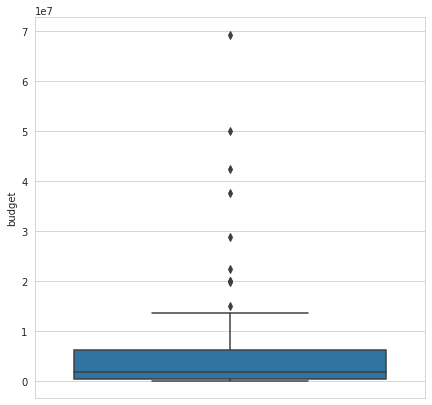

In [ ]:
plt.figure(figsize=(7,7))
sns.set_style('whitegrid')

data = dup_df['budget']

sns.boxplot(y=data)

In [ ]:
#filter outliers

outliers = [i for i in dup_df['budget'] if i > 6*(10**7)]
print('Outlier budget: ', outliers, 'this budget is more than :', 6*(10**7), ' million baht')
proj1 =''
prov1 = ''
proj2 = ''
prov2 = ''
proj3 = ''
prov3 = ''
for i in range(len(df_topic_1)):
  if df_topic_1.loc[i, 'budget'] == 69300000.0:
    proj1 = df_topic_1.loc[i, 'Project_name_Original']
    prov1 = df_topic_1.loc[i, 'province']
#  elif df_topic_1.loc[i, 'budget'] == 325710000.0:
#    proj2 = df_topic_1.loc[i, 'Project_name_Original']
#    prov2 = df_topic_1.loc[i, 'province']
#  elif df_topic_1.loc[i, 'budget'] == 366332000.0:
#    proj3 = df_topic_1.loc[i, 'Project_name_Original']
#    prov3 = df_topic_1.loc[i, 'province']
print('Project:')
print('1. ',proj1, ' ',prov1)
#print('2. ',proj2, ' ',prov2 )
#rint('3. ',proj3, ' ',prov3 )

Outlier budget:  [69300000.0] this budget is more than : 60000000  million baht
Project:
1.  โครงการก่อสร้างทางดินซีเมนต์ผสมโพลิเมอร์ (กึ่งคอนกรีต)   สุรินทร์


In [ ]:
labeldup_dfencoder = LabelEncoder()
dup_df['Project_name_Label'] = labelencoder.fit_transform(dup_df['Project_name_Original'])

In [ ]:
dup_df.head(200)

,Project_name_Original,province,budget,anomaly_old,digits,Project_name_Label
0,โครงการปรับปรุงอ่างเก็บน้ำบ้านเขาดิน หมู่ที่ 3...,ปัตตานี,7313000.0,1,7,56
1,โครงการปรับปรุงอ่างเก็บน้ำบ้านเขาดิน หมู่ที่ 3...,ปัตตานี,9924000.0,1,7,56
2,โครงการปรับปรุงถนนคอนกรีตเป็นแอสฟัสท์ติกคอนกรี...,ลำปาง,632000.0,1,6,48
3,โครงการก่อสร้างเสริมผิวถนนลาดยาง แอสฟัลท์ติกคอ...,ลำปาง,496000.0,1,6,34
4,โครงการปรับปรุงซ่อมแซมผิวถนนด้วยแอสฟัลท์ติกคอน...,ลำปาง,1826000.0,1,7,46
...,...,...,...,...,...,...
194,โครงการเสริมผิวจราจรแอสฟัลท์คอนกรีตสายภายในหมู...,สระแก้ว,495000.0,1,6,59
195,โครงการปรับปรุงถนนลูกรังสายภายในหมู่บ้าน,สระแก้ว,495000.0,1,6,52
196,โครงการปรับปรุงถนนลูกรังสายภายในหมู่บ้าน,สระแก้ว,495000.0,1,6,52
197,โครงการปรับปรุงซ่อมแซมถนน คอนกรีตเสริมเหล็ก คส...,ขอนแก่น,548209.0,1,6,43


In [ ]:
X = dup_df[['budget',  'Project_name_Label']]

from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100,  contamination=0.01, max_samples='auto', random_state=0)
clf.fit(X)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

In [ ]:
dup_df['scores']=clf.decision_function(X)
dup_df['anomaly_new']=clf.predict(X)
dup_df.head()

,Project_name_Original,province,budget,anomaly_old,digits,Project_name_Label,scores,anomaly_new
0,โครงการปรับปรุงอ่างเก็บน้ำบ้านเขาดิน หมู่ที่ 3...,ปัตตานี,7313000.0,1,7,56,0.111348,1
1,โครงการปรับปรุงอ่างเก็บน้ำบ้านเขาดิน หมู่ที่ 3...,ปัตตานี,9924000.0,1,7,56,0.060800,1
2,โครงการปรับปรุงถนนคอนกรีตเป็นแอสฟัสท์ติกคอนกรี...,ลำปาง,632000.0,1,6,48,0.261085,1
3,โครงการก่อสร้างเสริมผิวถนนลาดยาง แอสฟัลท์ติกคอ...,ลำปาง,496000.0,1,6,34,0.246032,1
4,โครงการปรับปรุงซ่อมแซมผิวถนนด้วยแอสฟัลท์ติกคอน...,ลำปาง,1826000.0,1,7,46,0.199351,1


In [ ]:
dup_df['anomaly_new'].value_counts()

 1    197
-1      2
Name: anomaly_new, dtype: int64

In [ ]:
anomaly_dup=dup_df.loc[dup_df['anomaly_new']==-1]
anomaly_dup

,Project_name_Original,province,budget,anomaly_old,digits,Project_name_Label,scores,anomaly_new
99,ซ่อมสร้างทางแอสฟัลต์ติกคอนกรีต,ร้อยเอ็ด,50000000.0,1,8,9,-0.023926,-1
167,โครงการก่อสร้างทางดินซีเมนต์ผสมโพลิเมอร์ (กึ่ง...,สุรินทร์,69300000.0,1,8,29,-0.103993,-1


In [ ]:
dg = dup_df.groupby(['digits', 'anomaly_new']).Project_name_Original.count().sort_values(ascending = False).reset_index()
dg

,digits,anomaly_new,Project_name_Original
0,7,1,95
1,6,1,90
2,8,1,12
3,8,-1,2


In [ ]:
anomaly_dup_index=list(anomaly_dup.index)

In [ ]:
r_dup = {'budget': dup_df['budget'],
     'project_name' : dup_df['Project_name_Label'],
     'anomaly' : dup_df['anomaly_new']}
res_dup = pd.DataFrame(r_dup)
res_dup.head(2)

,budget,project_name,anomaly
0,7313000.0,56,1
1,9924000.0,56,1


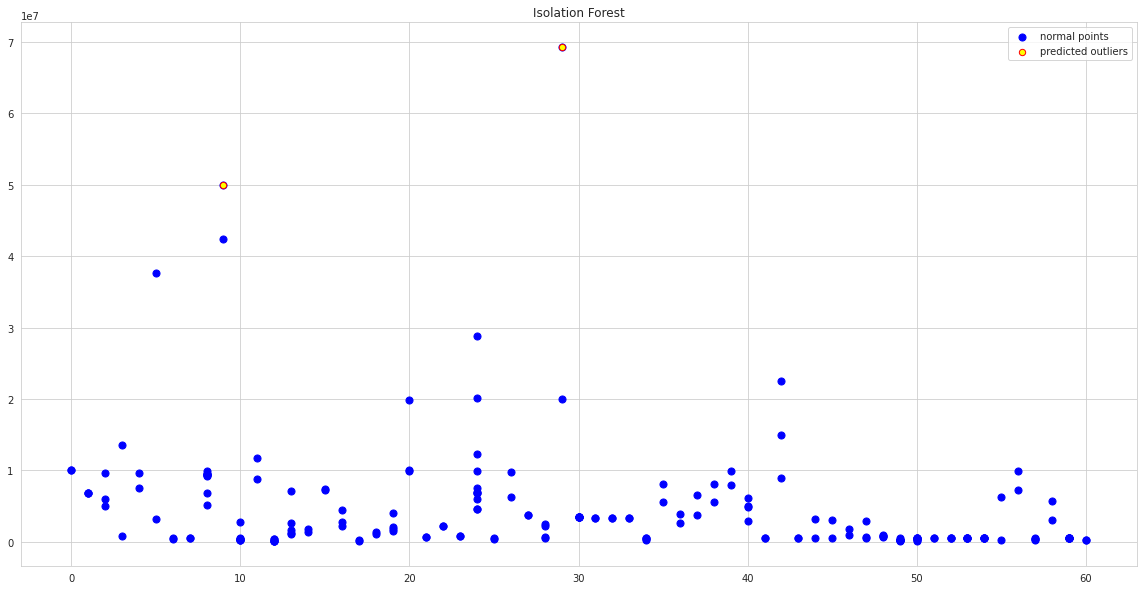

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Isolation Forest")
#plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(dup_df['Project_name_Label'], dup_df['budget'], c='blue',
                 s=50,label="normal points")

b1 =plt.scatter(res_dup.iloc[anomaly_dup_index,1],res_dup.iloc[anomaly_dup_index,0], c='yellow',s=40,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [ ]:
#filter outliers

outliers = [i for i in dup_df['budget'] if i >= 5*(10**7)]
print('Outlier budget: ', outliers, 'this budget is more than :', 5*(10**7), ' million baht')
proj1 =''
prov1 = ''
proj2 = ''
prov2 = ''
for i in range(len(dup_df)):
  if dup_df.loc[i, 'budget'] == 50000000.0:
    proj1 = dup_df.loc[i, 'Project_name_Original']
    prov1 = dup_df.loc[i, 'province']
  elif dup_df.loc[i, 'budget'] == 69300000.0:
    proj2 = dup_df.loc[i, 'Project_name_Original']
    prov2 = dup_df.loc[i, 'province']
print('Project:')
print('1. ',proj1, ' ',prov1)
print('2. ',proj2, ' ',prov2 )

Outlier budget:  [50000000.0, 69300000.0] this budget is more than : 50000000  million baht
Project:
1.  ซ่อมสร้างทางแอสฟัลต์ติกคอนกรีต   ร้อยเอ็ด
2.  โครงการก่อสร้างทางดินซีเมนต์ผสมโพลิเมอร์ (กึ่งคอนกรีต)   สุรินทร์


In [ ]:
anomaly_dup[['Project_name_Original','province','Project_name_Label','budget']].sort_values(by=['Project_name_Label'])

,Project_name_Original,province,Project_name_Label,budget
99,ซ่อมสร้างทางแอสฟัลต์ติกคอนกรีต,ร้อยเอ็ด,9,50000000.0
167,โครงการก่อสร้างทางดินซีเมนต์ผสมโพลิเมอร์ (กึ่ง...,สุรินทร์,29,69300000.0


In [ ]:
c=dup_df.loc[dup_df['Project_name_Original']=='โครงการก่อสร้างถนนคอนกรีตเสริมเหล็ก']
#c =c.sort_values(by=['Project_name_Original'])
c

,Project_name_Original,province,budget,anomaly_old,digits,Project_name_Label,scores,anomaly_new


#Save

In [ ]:
df_thaime.to_csv("/content/drive/My Drive/Colab Notebooks/IS/insight/df_thaime.csv", index=False)
df_thaime['project_name_clean'].to_csv("/content/drive/My Drive/Colab Notebooks/IS/insight/etc/project_n.csv", index=False)
df_for_cluster.to_csv("/content/drive/My Drive/Colab Notebooks/IS/insight/df_for_cluster.csv", index=False)

In [ ]:
dup_df.to_csv("/content/drive/My Drive/Colab Notebooks/IS/insight/dup_.csv", index=False)